# Import necessary libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array

2024-07-04 21:25:01.689425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 21:25:01.747486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 21:25:01.747522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 21:25:01.764667: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 21:25:03.375033: W tensorflow/compiler/tf

# Preprocessing and Data Preparation



In [ ]:
def prepare_data(train_dir):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


# Model Definitions


In [ ]:
def k_wta(x, percent=0.10):
    num_neurons = x.shape[-1]
    k = int(num_neurons * percent)
    k = max(1, k)
    k = min(num_neurons, k)
    top_k_values, _ = tf.math.top_k(x, k=k)
    threshold = tf.reduce_min(top_k_values)
    return tf.where(x >= threshold, x, 0)

In [ ]:
def build_model(activation='relu', percent=0.10):
    if activation == 'k_wta':
        activation = lambda x: k_wta(x, percent=percent)
    model = Sequential([
        Conv2D(8, (3, 3), padding='same', activation=activation, input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Conv2D(8, (5, 5), padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Conv2D(16, (5, 5), padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Conv2D(16, (5, 5), padding='same', activation=activation),
        BatchNormalization(),
        MaxPooling2D(pool_size=(4, 4), padding='same'),
        Flatten(),
        Dropout(0.5),
        Dense(16),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model


# Training Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
class BestHistory(Callback):
    def on_train_begin(self, logs=None):
        self.best_epoch = 0
        self.best_accuracy = 0.0
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > self.best_accuracy:
            self.best_accuracy = logs['val_accuracy']
            self.best_epoch = epoch
            for key in logs:
                if key not in self.history:
                    self.history[key] = []
                self.history[key].append(logs[key])

def train_model(model, train_data, val_data, epochs=50):
    # Callback to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)

    # Custom callback to store the history of the best validation accuracy
    best_history = BestHistory()

    # Train the model with callbacks
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        callbacks=[checkpoint, best_history],verbose=0)

    # Load the best model weights
    model.load_weights('best_model.keras')

    return best_history.history

# Adversarial Example Generation

Iterative FGSM Attack

In [ ]:
def iterative_fgsm(model, image, label, epsilon=0.002, iterations=5):
    adv_image = tf.expand_dims(image, axis=0)
    target_label = tf.expand_dims(label, axis=0)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            loss = tf.keras.losses.BinaryCrossentropy()(target_label, prediction)
        gradient = tape.gradient(loss, adv_image)
        signed_gradient = tf.sign(gradient)
        adv_image = adv_image + epsilon * signed_gradient
        adv_image = tf.clip_by_value(adv_image, 0.0, 1.0)

    return tf.squeeze(adv_image, axis=0)

C&W Attack

In [ ]:
def carlini_wagner_l2(model, x,label, num_iter=10, learning_rate=0.01, initial_c=0.01, c_range=(1e-4, 1e1)):
    # Determine the original prediction
    x = tf.expand_dims(x, axis=0)
    original_prediction = tf.cast(tf.expand_dims(tf.expand_dims(label, axis=0),axis=0),tf.float32)

    # Set the target class to be the opposite of the original prediction
    target = 1-original_prediction

    # Binary search for the best value of c
    c_min, c_max = c_range
    best_adv = None
    best_c = initial_c
    successful = False

    for _ in range(10):  # Adjust the range of search iterations if needed
        x_adv = tf.Variable(x, dtype=tf.float32)
        optimizer = tf.optimizers.Adam(learning_rate)
        target = tf.cast(target, tf.float32)
        c = best_c

        for i in range(num_iter):
            with tf.GradientTape() as tape:
                probabilities = model(x_adv)  # Assuming probabilities is a single value for binary classifier
                loss = attack_loss(probabilities, target, c, x, x_adv)
            gradients = tape.gradient(loss, x_adv)
            optimizer.apply_gradients([(gradients, x_adv)])
            x_adv.assign(tf.clip_by_value(x_adv, 0, 1))  # Ensure x_adv stays within valid image range

        adv_prediction = tf.round(model(x_adv))
        if adv_prediction != original_prediction:
            successful = True
            best_adv = x_adv
            c_max = best_c
        else:
            c_min = best_c

        best_c = (c_min + c_max) / 2

    if successful:
        return tf.squeeze(best_adv, axis=0)
    else:
        return tf.squeeze(x, axis=0)

def get_logits(model, x):
    return model(x)

def attack_loss(probabilities, target, c, original, adversarial):
    l2_dist = tf.reduce_sum(tf.square(adversarial - original))
    target_prob = target * probabilities
    other_prob = (1 - target) * probabilities
    f = tf.maximum(0.0, other_prob - target_prob + c)

    return l2_dist + tf.reduce_sum(f)

# Evaluation and Plotting

In [ ]:
def evaluate_model(model, images, labels):
    if len(images.shape) == 3:
        images = np.expand_dims(images, axis=0)

    predictions = model.predict(images)
    y_true = labels
    y_pred = (predictions > 0.5).astype(int).reshape(-1)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=['Fake', 'Real'])

    return cm, cr

def plot_results(history, cm, cr, title_suffix):
    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training and Validation Accuracy {title_suffix}')

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss {title_suffix}')
    plt.show()

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix {title_suffix}')
    plt.show()

    print(f'Classification Report {title_suffix}:')
    print(cr)


# Main Function

Found 798 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-04 21:25:09.759023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21914 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:03:00.0, compute capability: 8.9
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its construc

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step


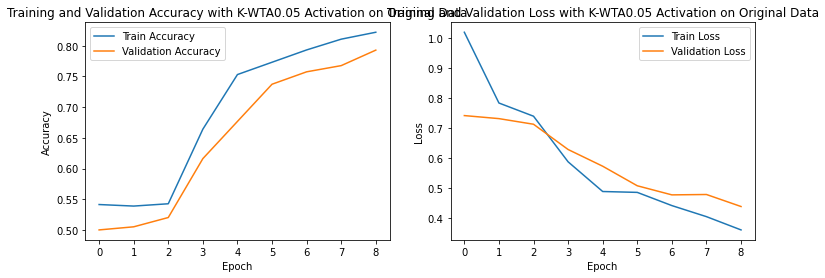

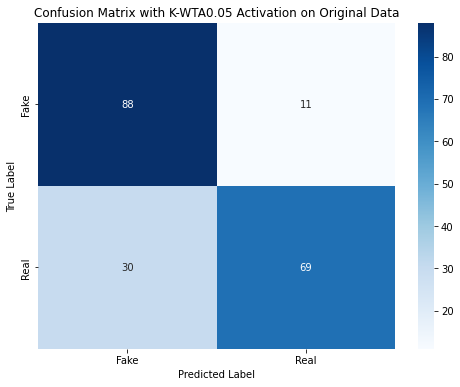

Classification Report with K-WTA0.05 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.75      0.89      0.81        99
        Real       0.86      0.70      0.77        99

    accuracy                           0.79       198
   macro avg       0.80      0.79      0.79       198
weighted avg       0.80      0.79      0.79       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


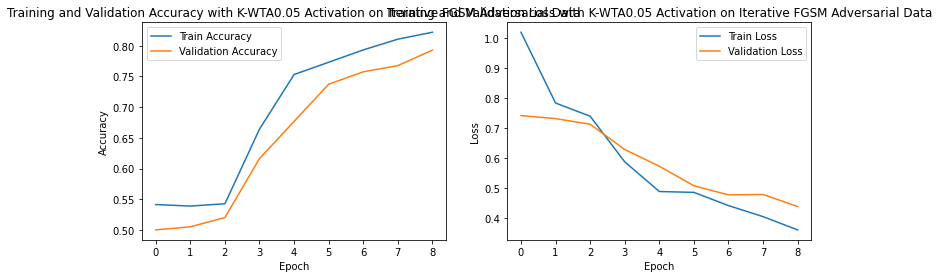

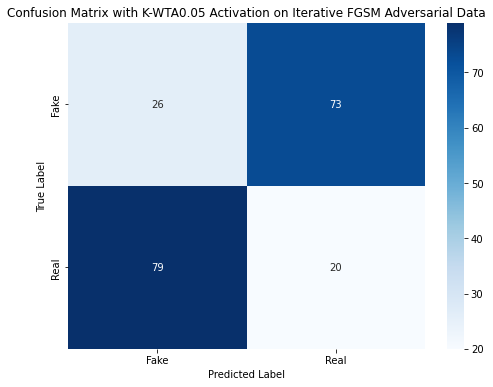

Classification Report with K-WTA0.05 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.25      0.26      0.25        99
        Real       0.22      0.20      0.21        99

    accuracy                           0.23       198
   macro avg       0.23      0.23      0.23       198
weighted avg       0.23      0.23      0.23       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


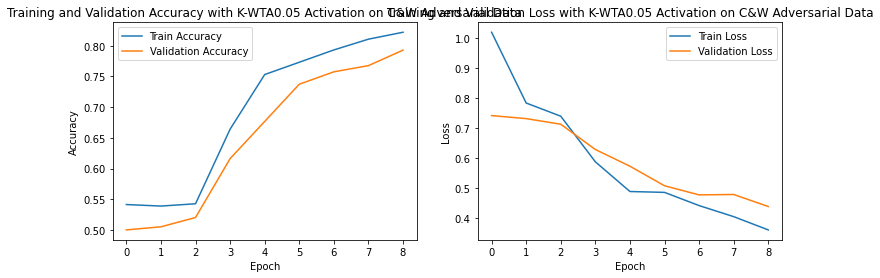

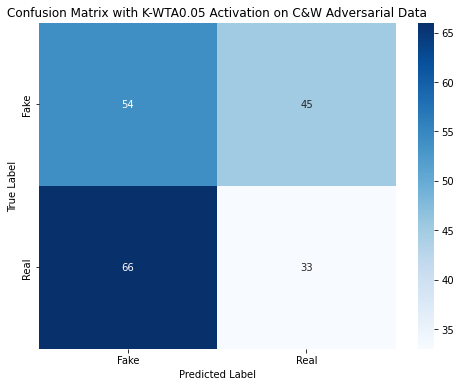

Classification Report with K-WTA0.05 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.45      0.55      0.49        99
        Real       0.42      0.33      0.37        99

    accuracy                           0.44       198
   macro avg       0.44      0.44      0.43       198
weighted avg       0.44      0.44      0.43       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


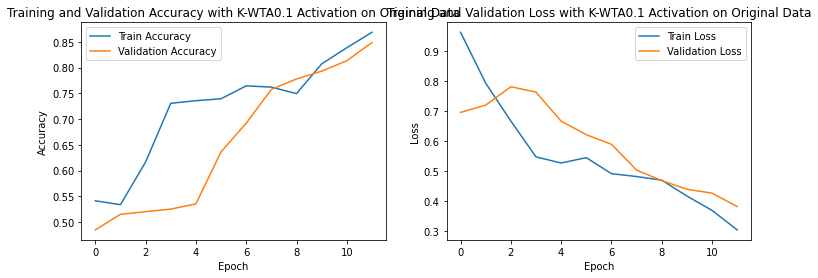

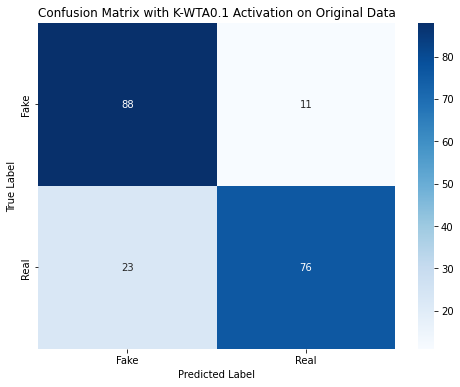

Classification Report with K-WTA0.1 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.79      0.89      0.84        99
        Real       0.87      0.77      0.82        99

    accuracy                           0.83       198
   macro avg       0.83      0.83      0.83       198
weighted avg       0.83      0.83      0.83       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


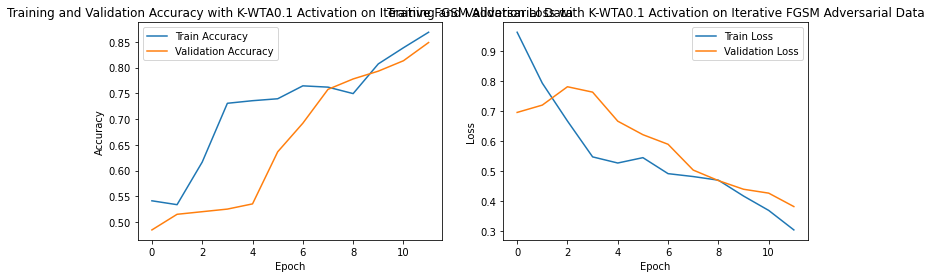

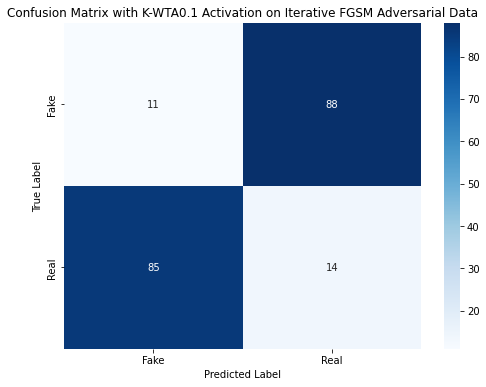

Classification Report with K-WTA0.1 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.11      0.11      0.11        99
        Real       0.14      0.14      0.14        99

    accuracy                           0.13       198
   macro avg       0.13      0.13      0.13       198
weighted avg       0.13      0.13      0.13       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


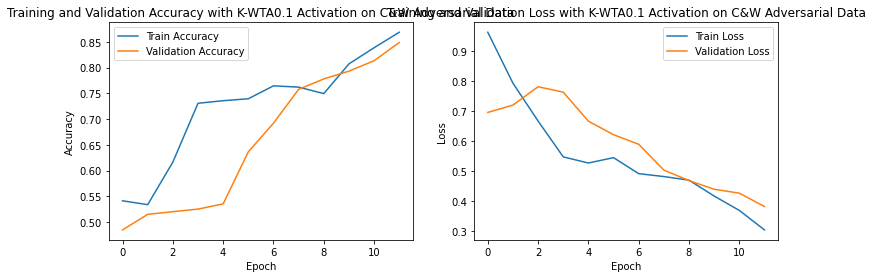

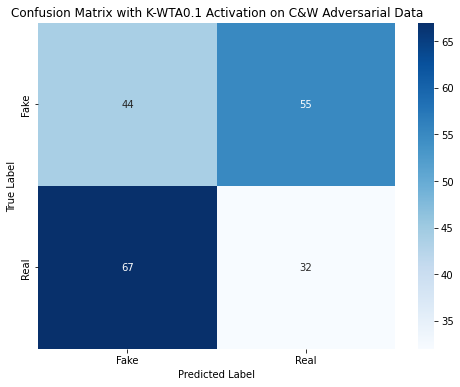

Classification Report with K-WTA0.1 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.40      0.44      0.42        99
        Real       0.37      0.32      0.34        99

    accuracy                           0.38       198
   macro avg       0.38      0.38      0.38       198
weighted avg       0.38      0.38      0.38       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step


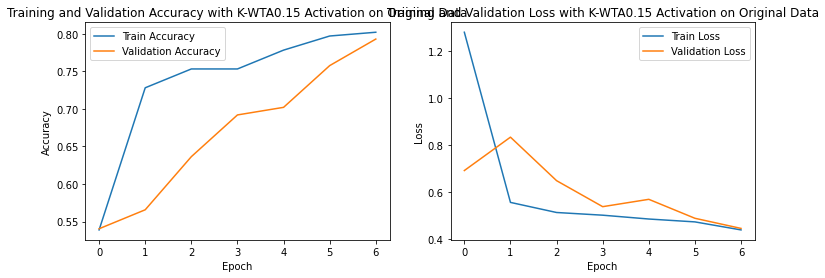

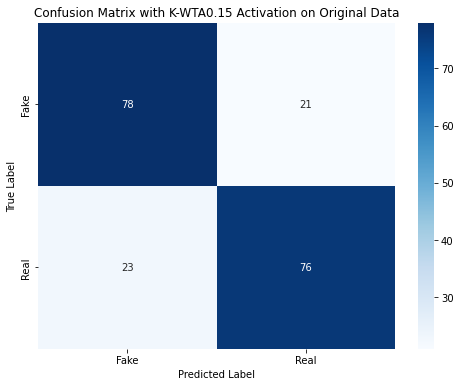

Classification Report with K-WTA0.15 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.77      0.79      0.78        99
        Real       0.78      0.77      0.78        99

    accuracy                           0.78       198
   macro avg       0.78      0.78      0.78       198
weighted avg       0.78      0.78      0.78       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


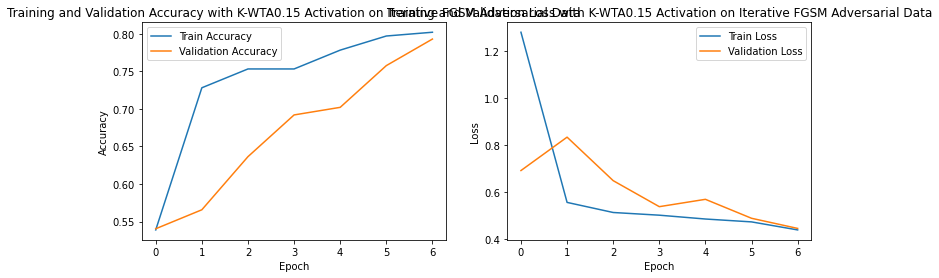

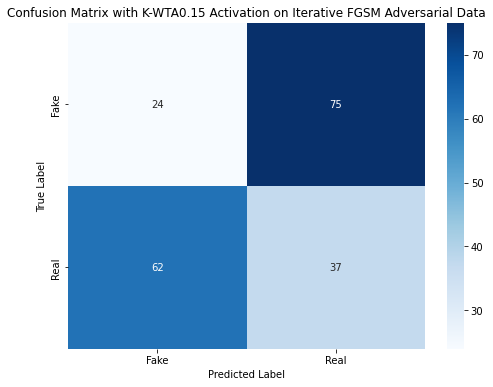

Classification Report with K-WTA0.15 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.28      0.24      0.26        99
        Real       0.33      0.37      0.35        99

    accuracy                           0.31       198
   macro avg       0.30      0.31      0.31       198
weighted avg       0.30      0.31      0.31       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


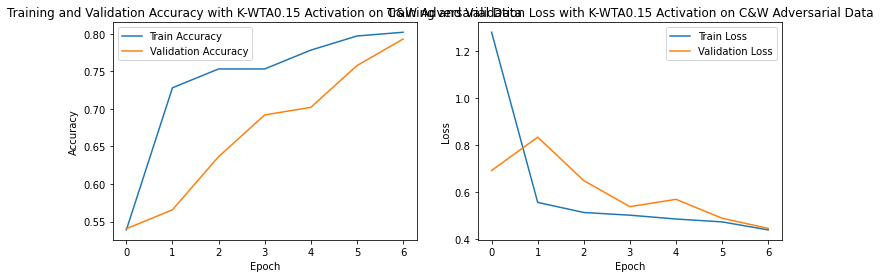

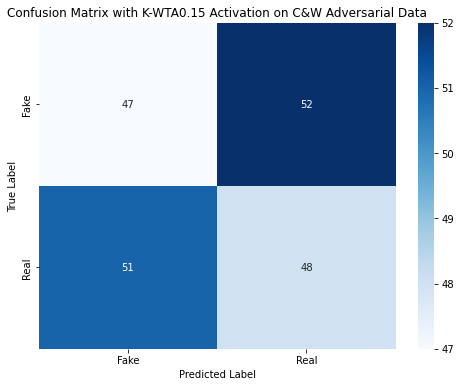

Classification Report with K-WTA0.15 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.48      0.47      0.48        99
        Real       0.48      0.48      0.48        99

    accuracy                           0.48       198
   macro avg       0.48      0.48      0.48       198
weighted avg       0.48      0.48      0.48       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step


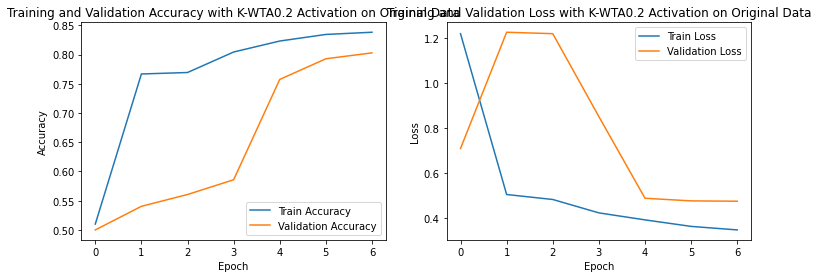

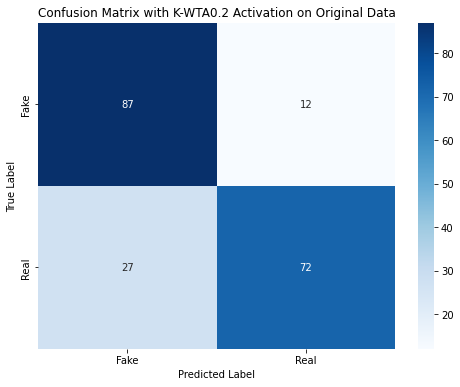

Classification Report with K-WTA0.2 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.76      0.88      0.82        99
        Real       0.86      0.73      0.79        99

    accuracy                           0.80       198
   macro avg       0.81      0.80      0.80       198
weighted avg       0.81      0.80      0.80       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


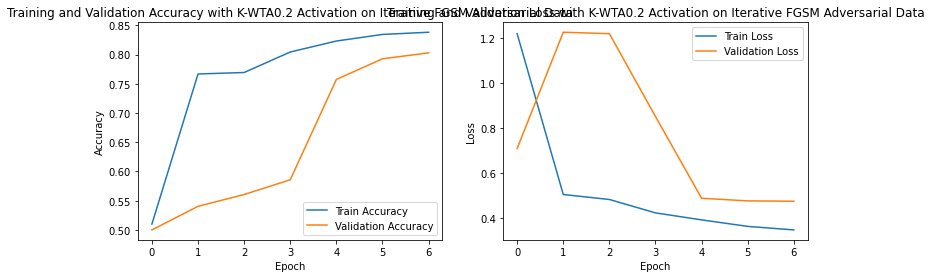

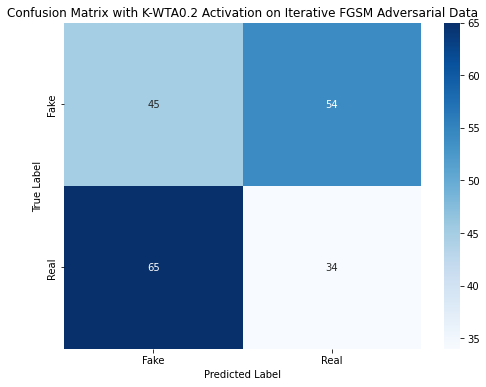

Classification Report with K-WTA0.2 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.41      0.45      0.43        99
        Real       0.39      0.34      0.36        99

    accuracy                           0.40       198
   macro avg       0.40      0.40      0.40       198
weighted avg       0.40      0.40      0.40       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


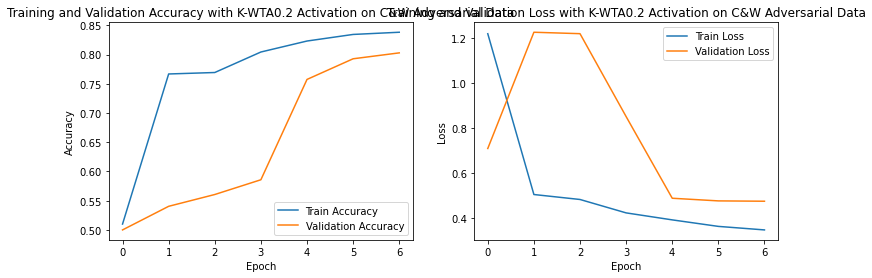

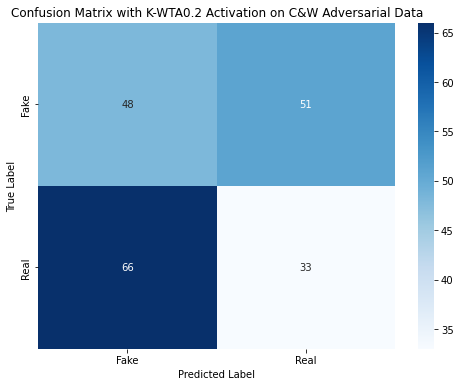

Classification Report with K-WTA0.2 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.42      0.48      0.45        99
        Real       0.39      0.33      0.36        99

    accuracy                           0.41       198
   macro avg       0.41      0.41      0.41       198
weighted avg       0.41      0.41      0.41       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


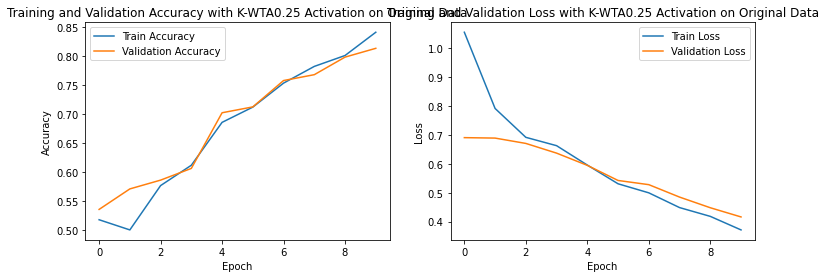

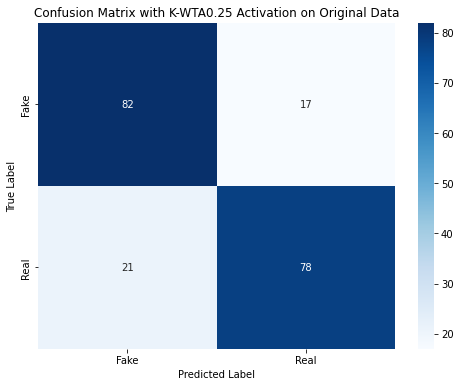

Classification Report with K-WTA0.25 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.80      0.83      0.81        99
        Real       0.82      0.79      0.80        99

    accuracy                           0.81       198
   macro avg       0.81      0.81      0.81       198
weighted avg       0.81      0.81      0.81       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


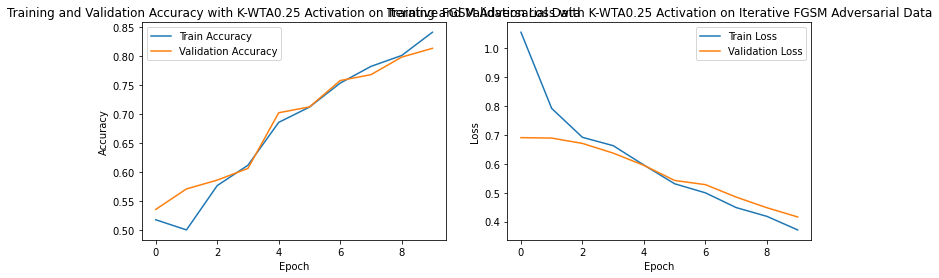

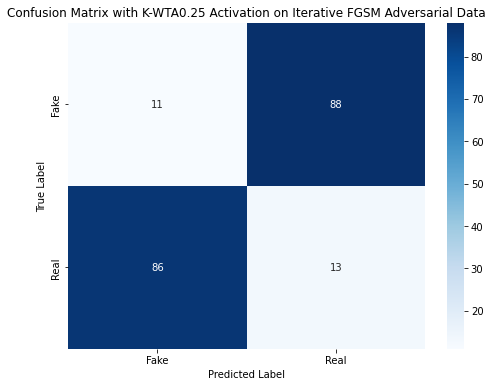

Classification Report with K-WTA0.25 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.11      0.11      0.11        99
        Real       0.13      0.13      0.13        99

    accuracy                           0.12       198
   macro avg       0.12      0.12      0.12       198
weighted avg       0.12      0.12      0.12       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


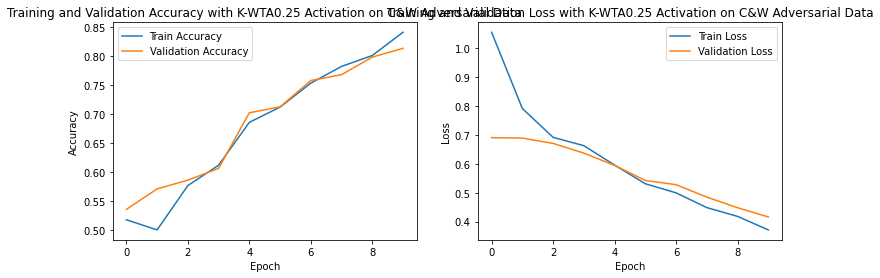

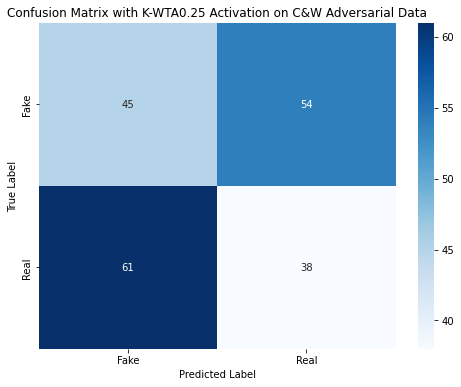

Classification Report with K-WTA0.25 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.42      0.45      0.44        99
        Real       0.41      0.38      0.40        99

    accuracy                           0.42       198
   macro avg       0.42      0.42      0.42       198
weighted avg       0.42      0.42      0.42       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step


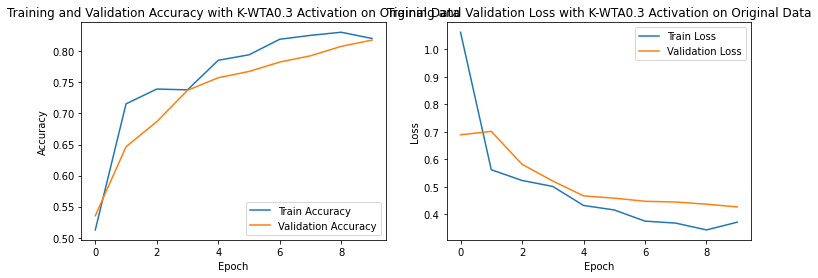

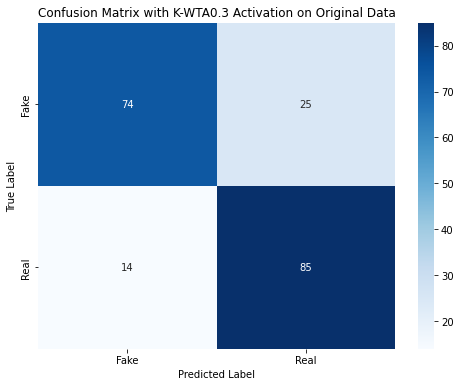

Classification Report with K-WTA0.3 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.84      0.75      0.79        99
        Real       0.77      0.86      0.81        99

    accuracy                           0.80       198
   macro avg       0.81      0.80      0.80       198
weighted avg       0.81      0.80      0.80       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


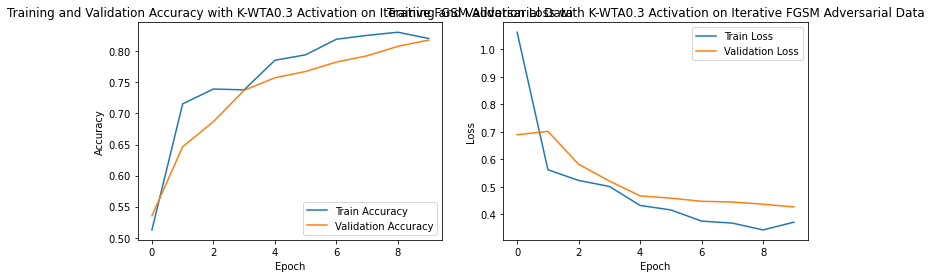

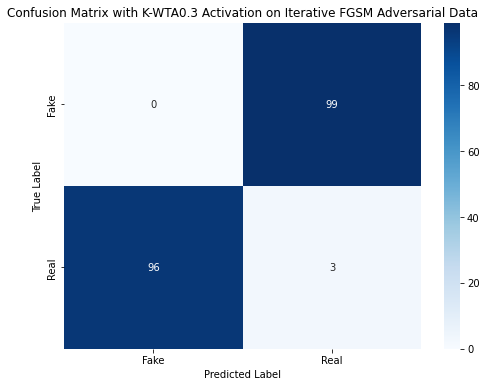

Classification Report with K-WTA0.3 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00        99
        Real       0.03      0.03      0.03        99

    accuracy                           0.02       198
   macro avg       0.01      0.02      0.01       198
weighted avg       0.01      0.02      0.01       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


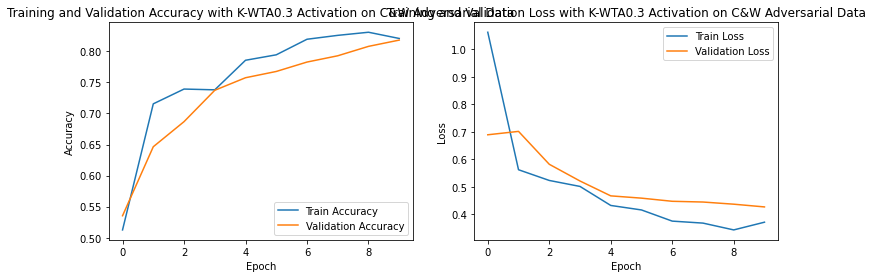

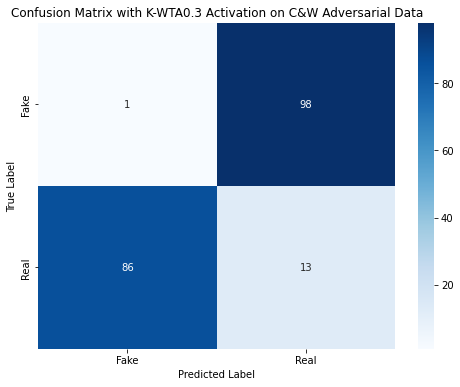

Classification Report with K-WTA0.3 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.01      0.01      0.01        99
        Real       0.12      0.13      0.12        99

    accuracy                           0.07       198
   macro avg       0.06      0.07      0.07       198
weighted avg       0.06      0.07      0.07       198

Found 798 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


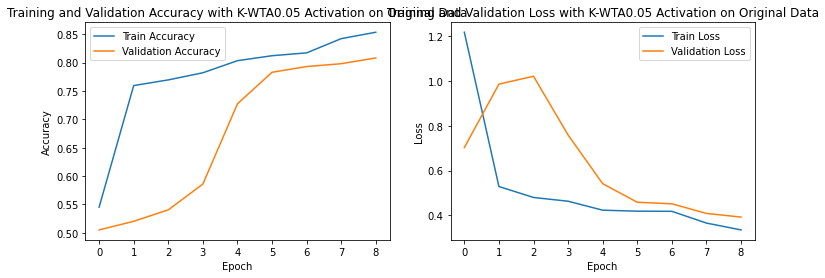

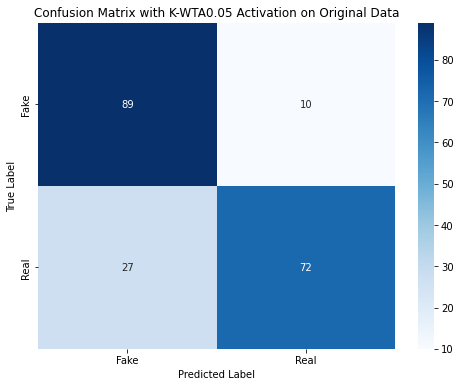

Classification Report with K-WTA0.05 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.77      0.90      0.83        99
        Real       0.88      0.73      0.80        99

    accuracy                           0.81       198
   macro avg       0.82      0.81      0.81       198
weighted avg       0.82      0.81      0.81       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


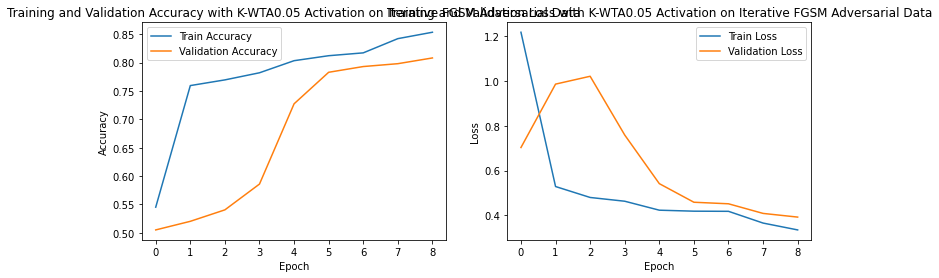

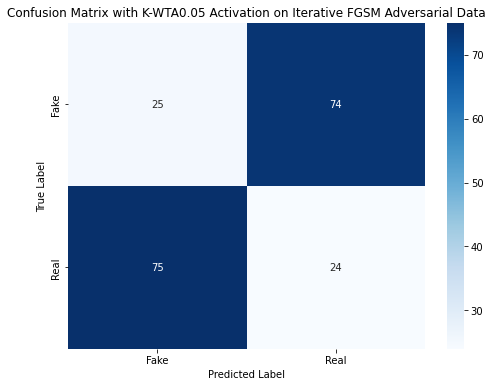

Classification Report with K-WTA0.05 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.25      0.25      0.25        99
        Real       0.24      0.24      0.24        99

    accuracy                           0.25       198
   macro avg       0.25      0.25      0.25       198
weighted avg       0.25      0.25      0.25       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


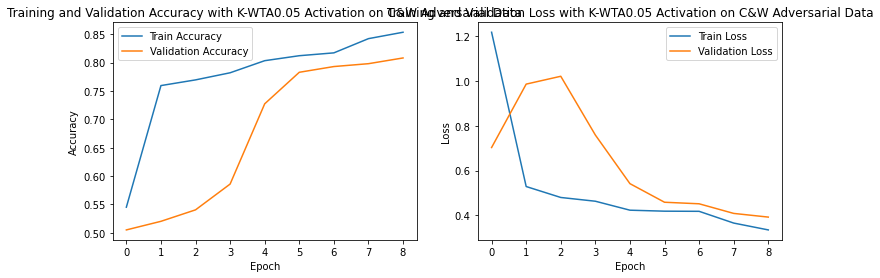

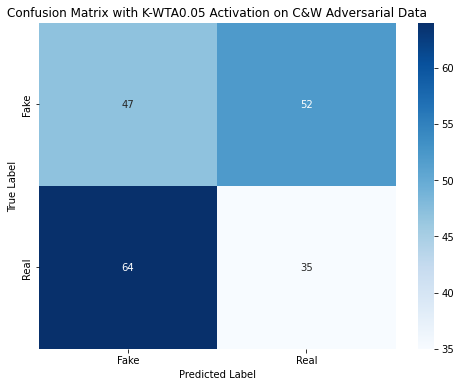

Classification Report with K-WTA0.05 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.42      0.47      0.45        99
        Real       0.40      0.35      0.38        99

    accuracy                           0.41       198
   macro avg       0.41      0.41      0.41       198
weighted avg       0.41      0.41      0.41       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


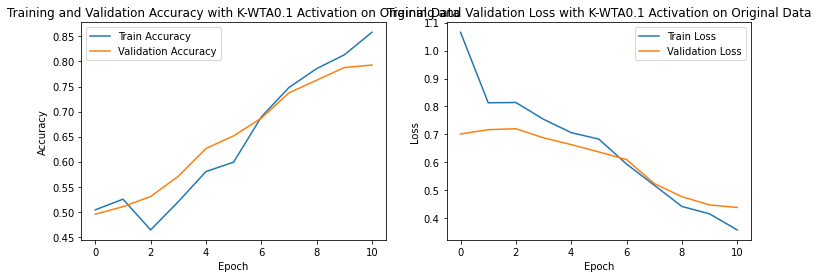

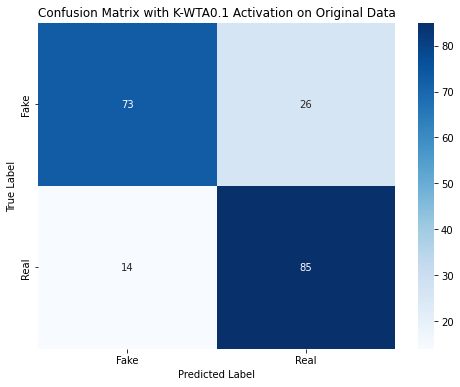

Classification Report with K-WTA0.1 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.84      0.74      0.78        99
        Real       0.77      0.86      0.81        99

    accuracy                           0.80       198
   macro avg       0.80      0.80      0.80       198
weighted avg       0.80      0.80      0.80       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


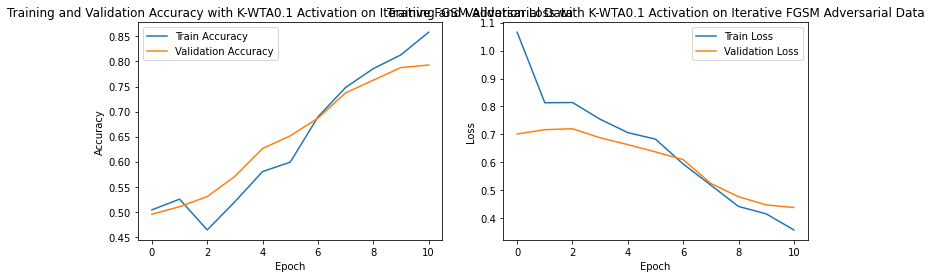

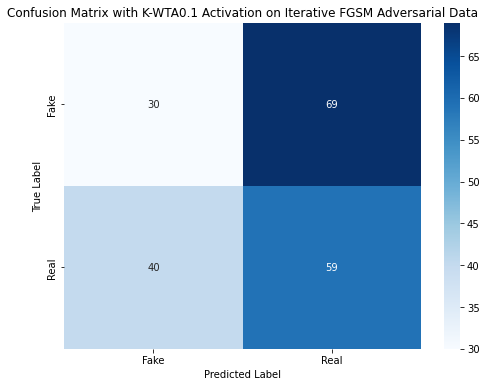

Classification Report with K-WTA0.1 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.43      0.30      0.36        99
        Real       0.46      0.60      0.52        99

    accuracy                           0.45       198
   macro avg       0.44      0.45      0.44       198
weighted avg       0.44      0.45      0.44       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


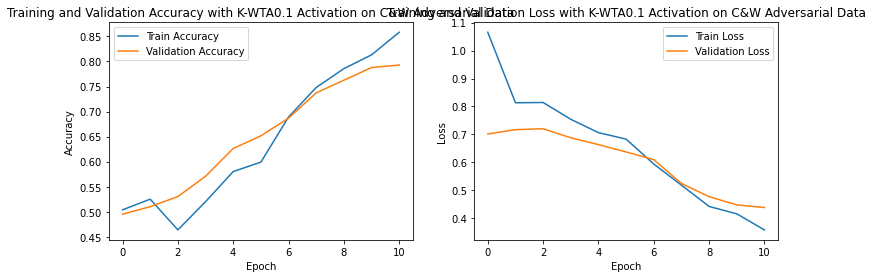

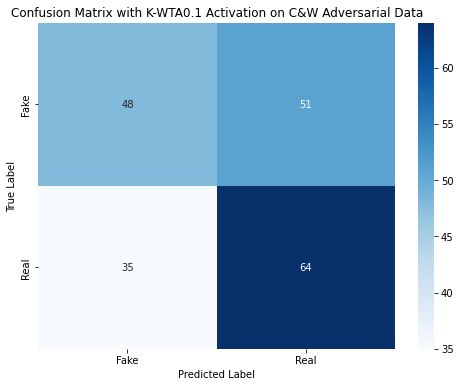

Classification Report with K-WTA0.1 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.58      0.48      0.53        99
        Real       0.56      0.65      0.60        99

    accuracy                           0.57       198
   macro avg       0.57      0.57      0.56       198
weighted avg       0.57      0.57      0.56       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step


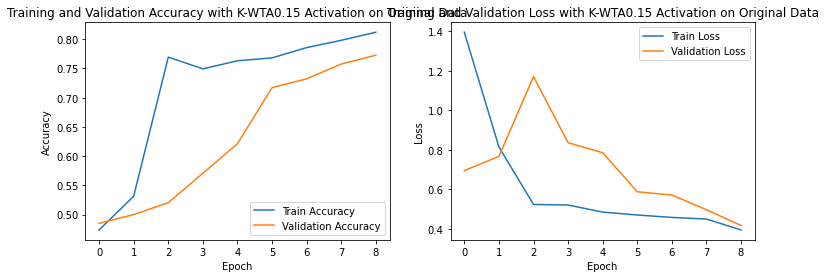

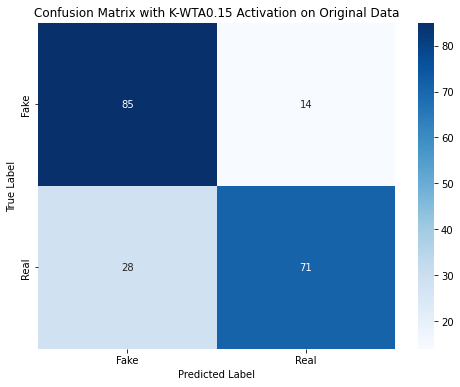

Classification Report with K-WTA0.15 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.75      0.86      0.80        99
        Real       0.84      0.72      0.77        99

    accuracy                           0.79       198
   macro avg       0.79      0.79      0.79       198
weighted avg       0.79      0.79      0.79       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


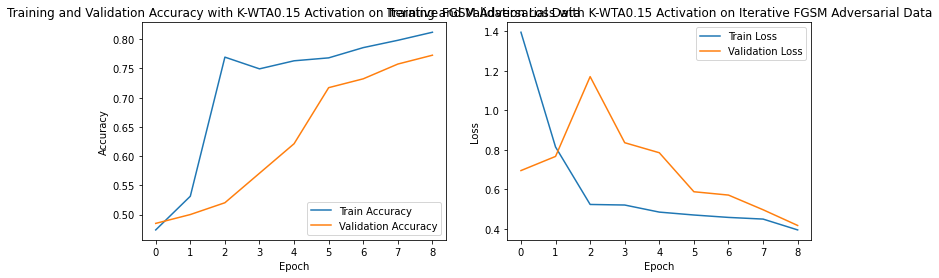

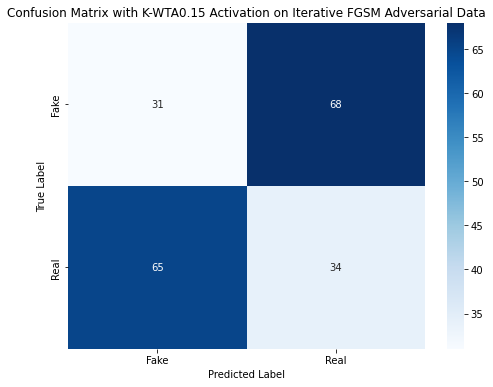

Classification Report with K-WTA0.15 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.32      0.31      0.32        99
        Real       0.33      0.34      0.34        99

    accuracy                           0.33       198
   macro avg       0.33      0.33      0.33       198
weighted avg       0.33      0.33      0.33       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


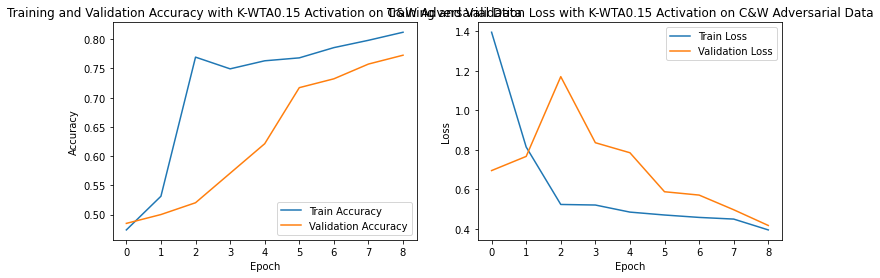

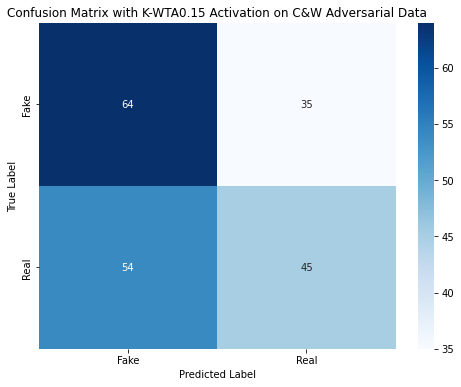

Classification Report with K-WTA0.15 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.54      0.65      0.59        99
        Real       0.56      0.45      0.50        99

    accuracy                           0.55       198
   macro avg       0.55      0.55      0.55       198
weighted avg       0.55      0.55      0.55       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step


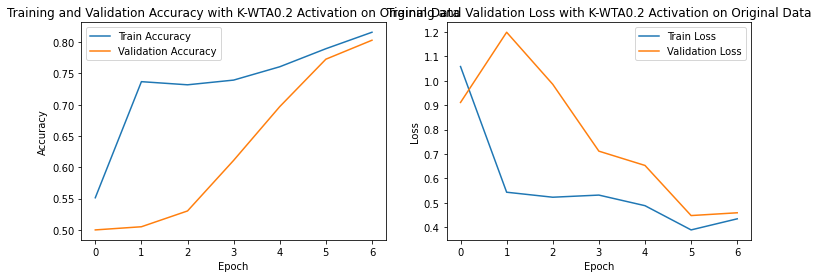

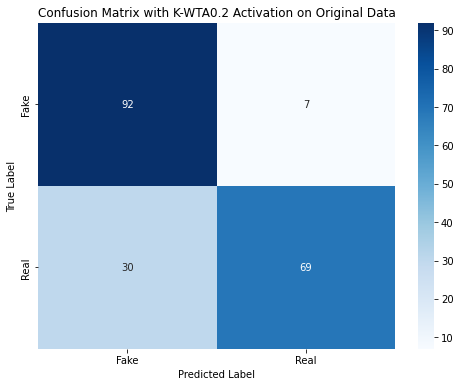

Classification Report with K-WTA0.2 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.75      0.93      0.83        99
        Real       0.91      0.70      0.79        99

    accuracy                           0.81       198
   macro avg       0.83      0.81      0.81       198
weighted avg       0.83      0.81      0.81       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


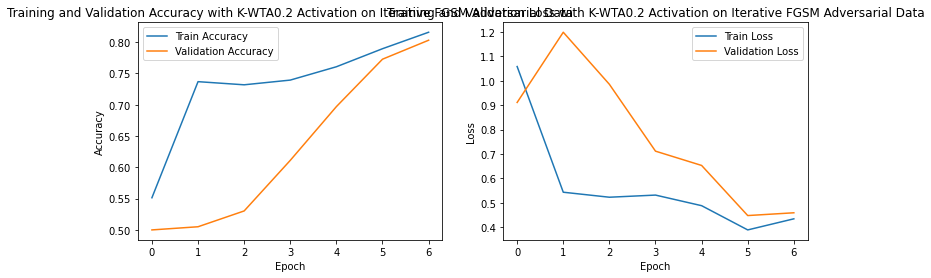

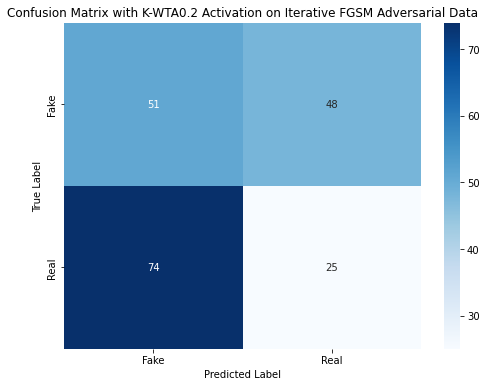

Classification Report with K-WTA0.2 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.41      0.52      0.46        99
        Real       0.34      0.25      0.29        99

    accuracy                           0.38       198
   macro avg       0.38      0.38      0.37       198
weighted avg       0.38      0.38      0.37       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


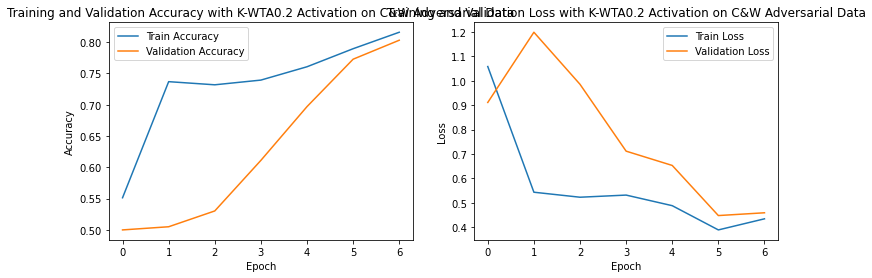

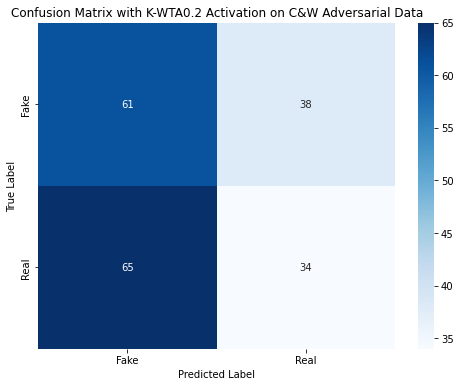

Classification Report with K-WTA0.2 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.48      0.62      0.54        99
        Real       0.47      0.34      0.40        99

    accuracy                           0.48       198
   macro avg       0.48      0.48      0.47       198
weighted avg       0.48      0.48      0.47       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


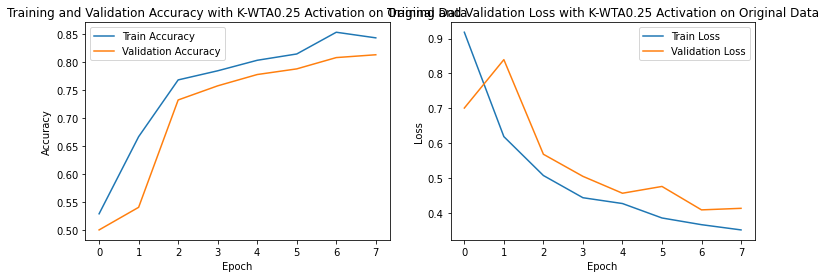

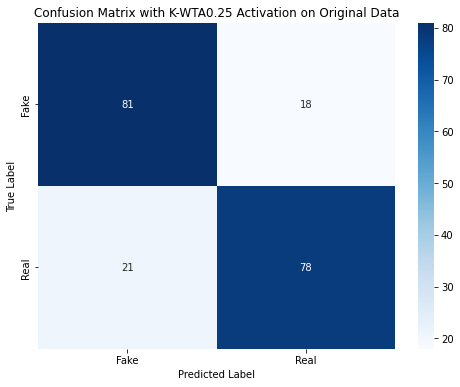

Classification Report with K-WTA0.25 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.79      0.82      0.81        99
        Real       0.81      0.79      0.80        99

    accuracy                           0.80       198
   macro avg       0.80      0.80      0.80       198
weighted avg       0.80      0.80      0.80       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


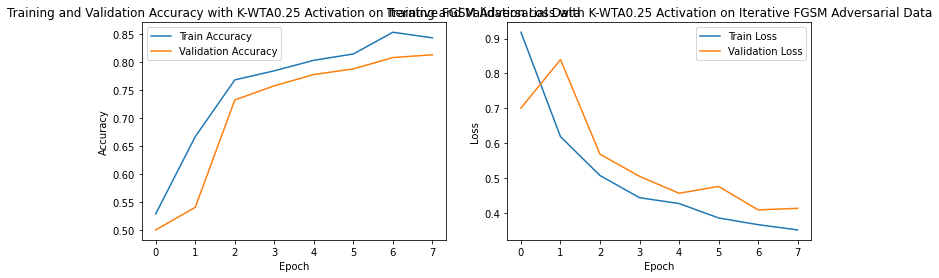

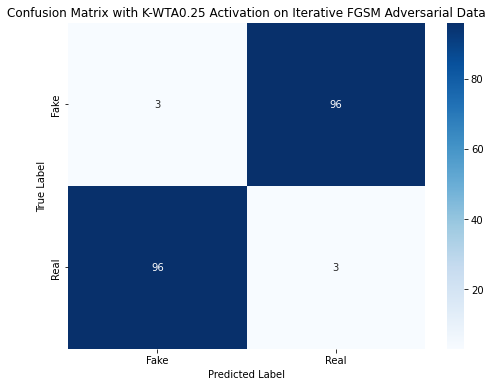

Classification Report with K-WTA0.25 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.03      0.03      0.03        99
        Real       0.03      0.03      0.03        99

    accuracy                           0.03       198
   macro avg       0.03      0.03      0.03       198
weighted avg       0.03      0.03      0.03       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


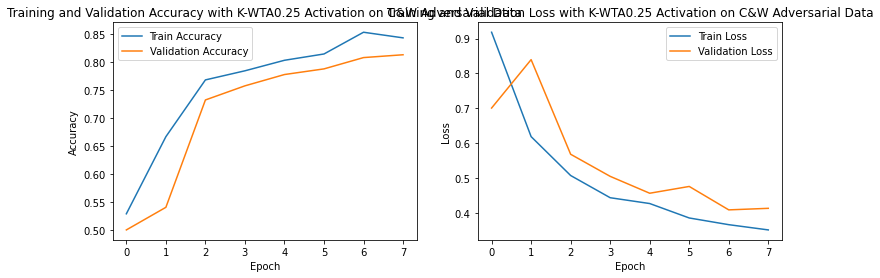

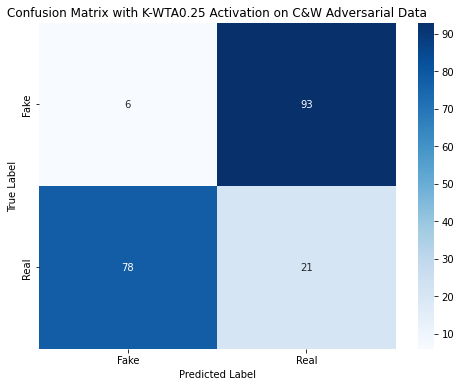

Classification Report with K-WTA0.25 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.07      0.06      0.07        99
        Real       0.18      0.21      0.20        99

    accuracy                           0.14       198
   macro avg       0.13      0.14      0.13       198
weighted avg       0.13      0.14      0.13       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


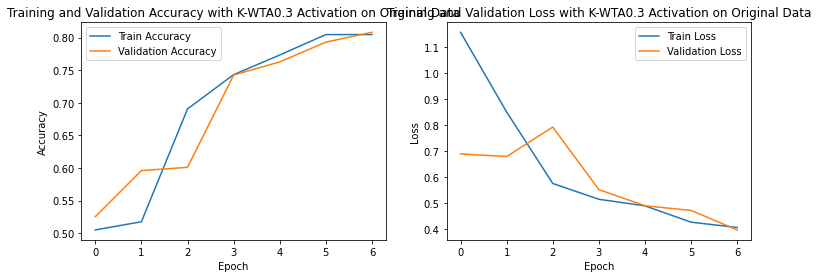

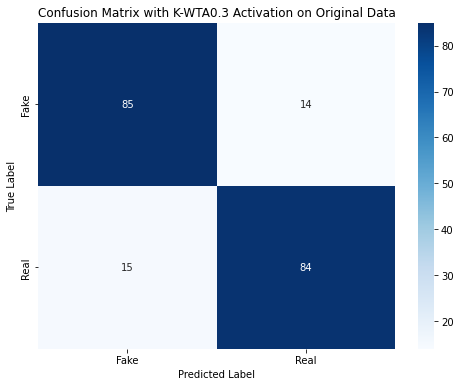

Classification Report with K-WTA0.3 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.85      0.86      0.85        99
        Real       0.86      0.85      0.85        99

    accuracy                           0.85       198
   macro avg       0.85      0.85      0.85       198
weighted avg       0.85      0.85      0.85       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


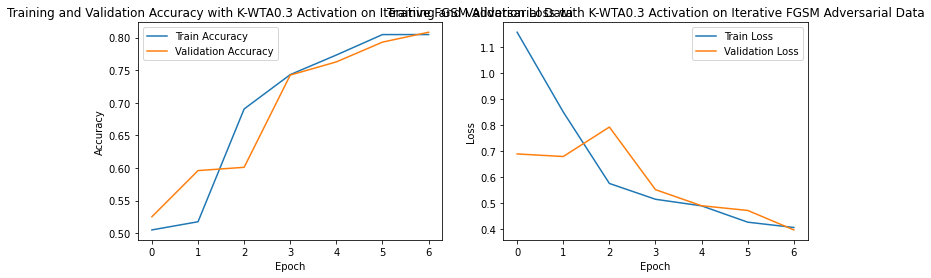

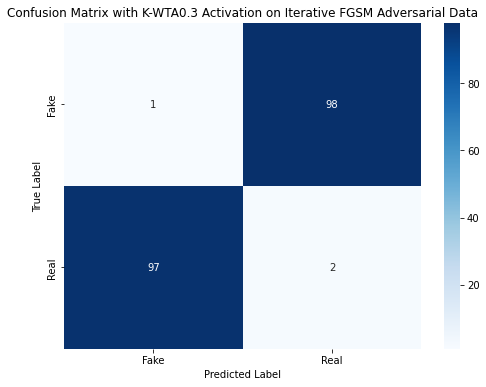

Classification Report with K-WTA0.3 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.01      0.01      0.01        99
        Real       0.02      0.02      0.02        99

    accuracy                           0.02       198
   macro avg       0.02      0.02      0.02       198
weighted avg       0.02      0.02      0.02       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


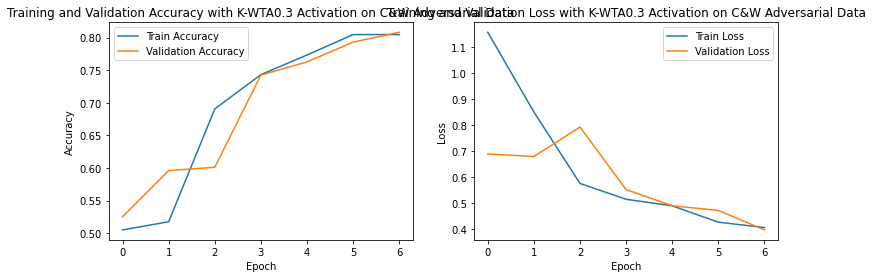

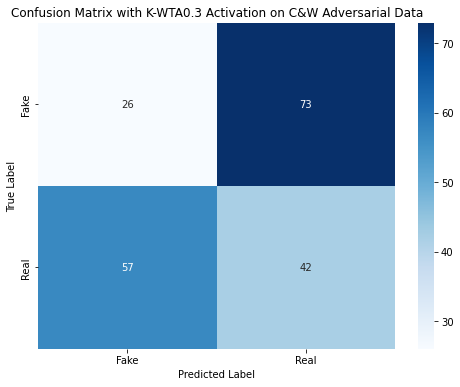

Classification Report with K-WTA0.3 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.31      0.26      0.29        99
        Real       0.37      0.42      0.39        99

    accuracy                           0.34       198
   macro avg       0.34      0.34      0.34       198
weighted avg       0.34      0.34      0.34       198

Found 798 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step


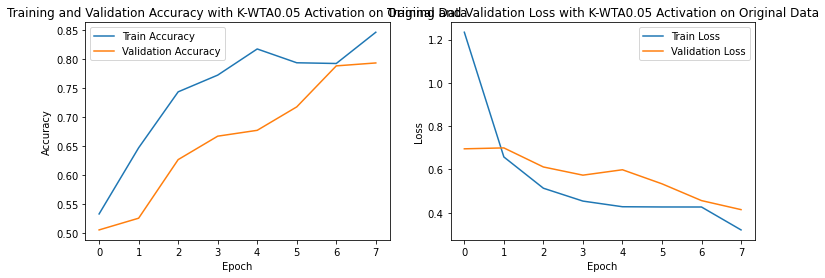

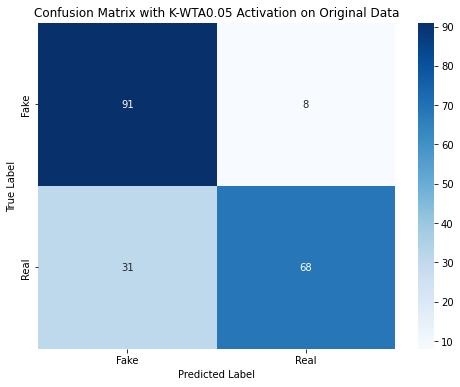

Classification Report with K-WTA0.05 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.75      0.92      0.82        99
        Real       0.89      0.69      0.78        99

    accuracy                           0.80       198
   macro avg       0.82      0.80      0.80       198
weighted avg       0.82      0.80      0.80       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


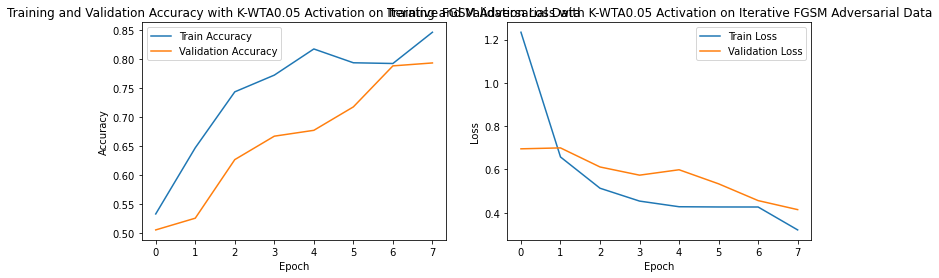

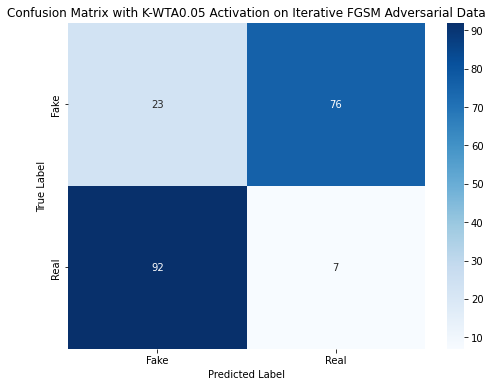

Classification Report with K-WTA0.05 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.20      0.23      0.21        99
        Real       0.08      0.07      0.08        99

    accuracy                           0.15       198
   macro avg       0.14      0.15      0.15       198
weighted avg       0.14      0.15      0.15       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


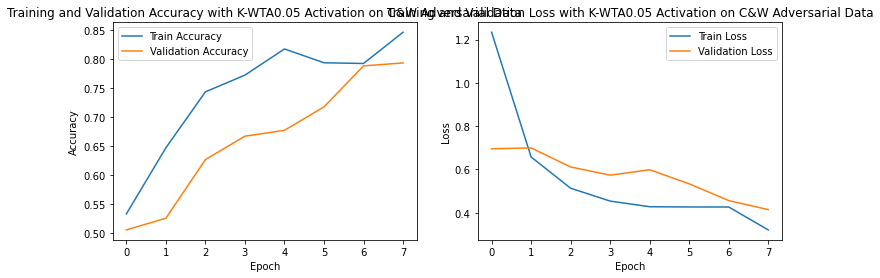

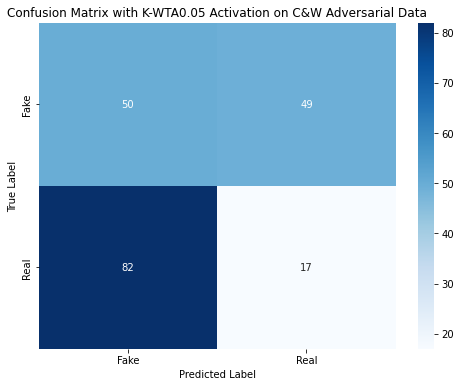

Classification Report with K-WTA0.05 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.38      0.51      0.43        99
        Real       0.26      0.17      0.21        99

    accuracy                           0.34       198
   macro avg       0.32      0.34      0.32       198
weighted avg       0.32      0.34      0.32       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


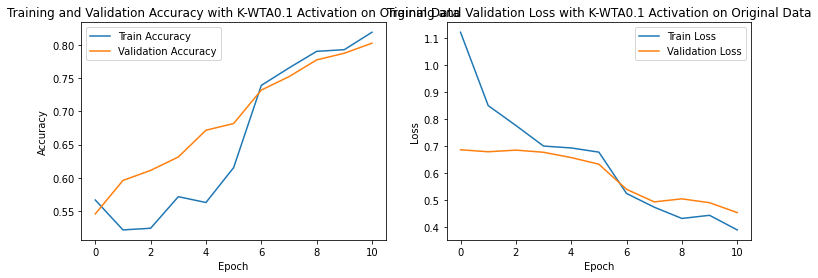

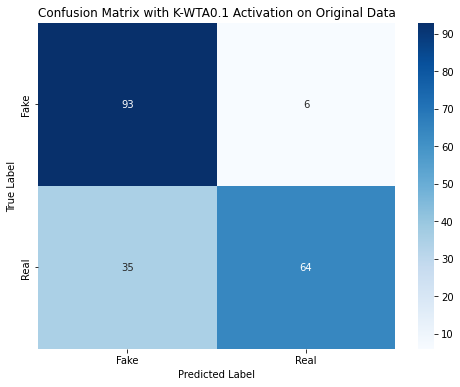

Classification Report with K-WTA0.1 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.73      0.94      0.82        99
        Real       0.91      0.65      0.76        99

    accuracy                           0.79       198
   macro avg       0.82      0.79      0.79       198
weighted avg       0.82      0.79      0.79       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


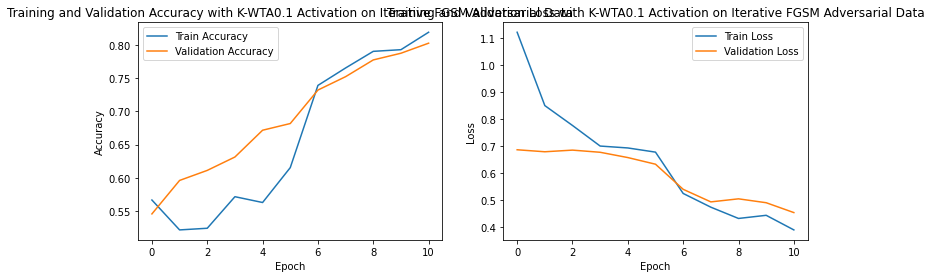

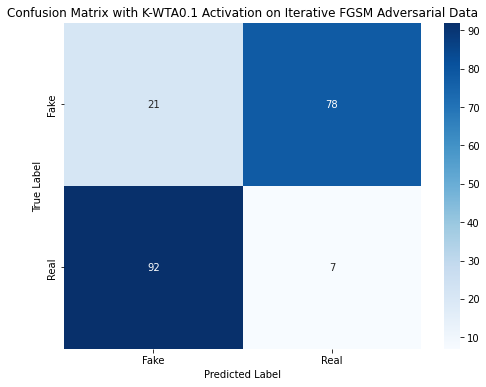

Classification Report with K-WTA0.1 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.19      0.21      0.20        99
        Real       0.08      0.07      0.08        99

    accuracy                           0.14       198
   macro avg       0.13      0.14      0.14       198
weighted avg       0.13      0.14      0.14       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


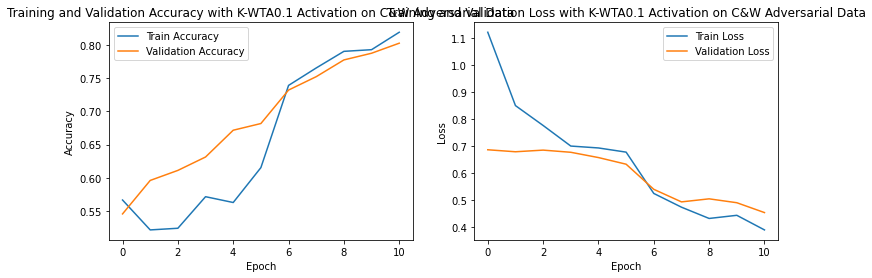

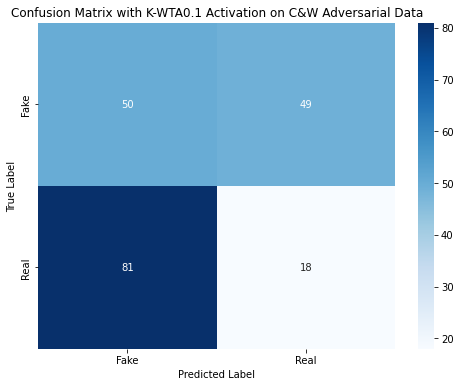

Classification Report with K-WTA0.1 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.38      0.51      0.43        99
        Real       0.27      0.18      0.22        99

    accuracy                           0.34       198
   macro avg       0.33      0.34      0.33       198
weighted avg       0.33      0.34      0.33       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


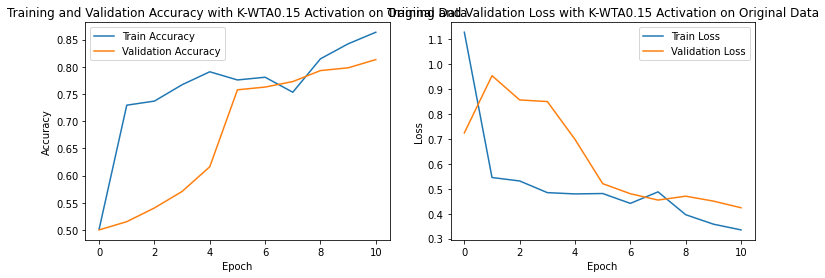

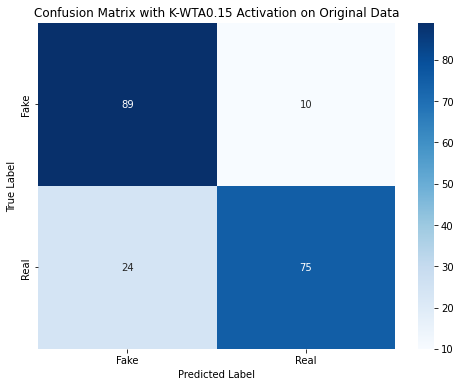

Classification Report with K-WTA0.15 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.79      0.90      0.84        99
        Real       0.88      0.76      0.82        99

    accuracy                           0.83       198
   macro avg       0.83      0.83      0.83       198
weighted avg       0.83      0.83      0.83       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


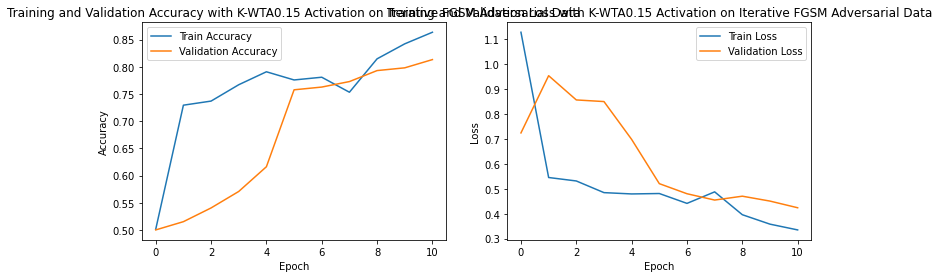

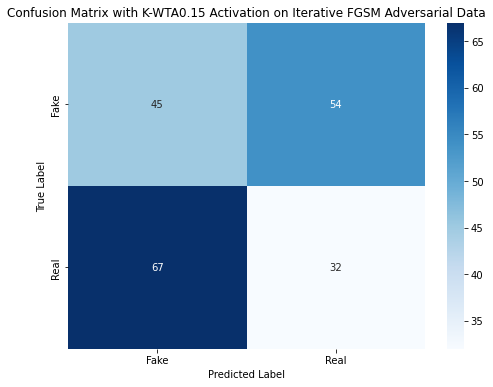

Classification Report with K-WTA0.15 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.40      0.45      0.43        99
        Real       0.37      0.32      0.35        99

    accuracy                           0.39       198
   macro avg       0.39      0.39      0.39       198
weighted avg       0.39      0.39      0.39       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


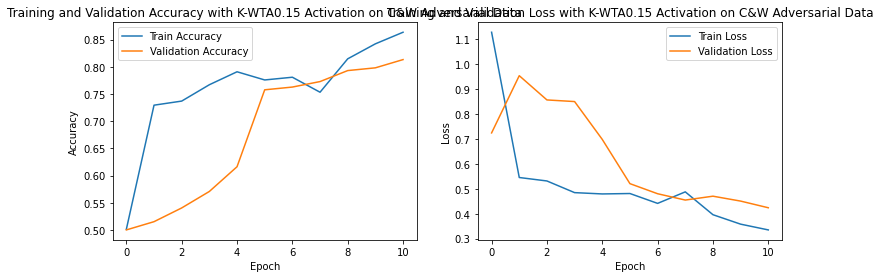

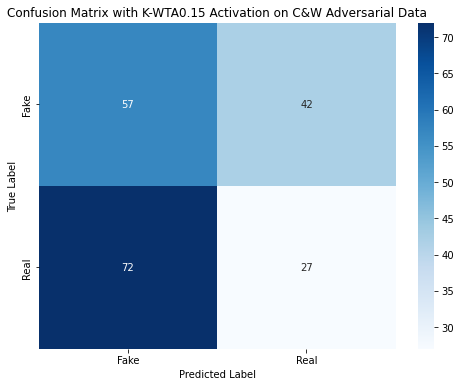

Classification Report with K-WTA0.15 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.44      0.58      0.50        99
        Real       0.39      0.27      0.32        99

    accuracy                           0.42       198
   macro avg       0.42      0.42      0.41       198
weighted avg       0.42      0.42      0.41       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


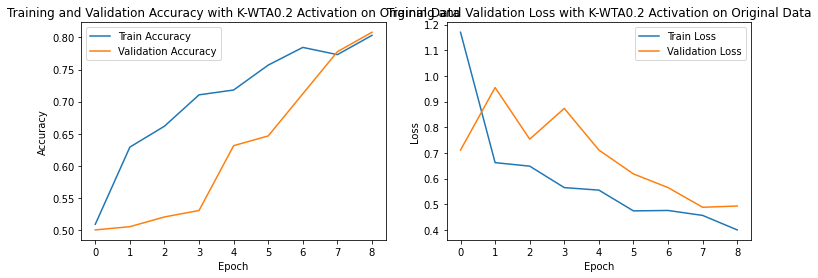

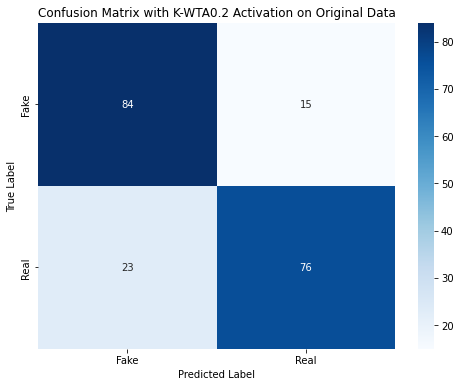

Classification Report with K-WTA0.2 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.79      0.85      0.82        99
        Real       0.84      0.77      0.80        99

    accuracy                           0.81       198
   macro avg       0.81      0.81      0.81       198
weighted avg       0.81      0.81      0.81       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


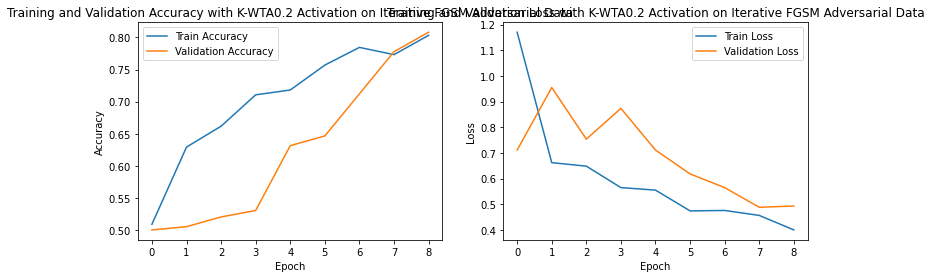

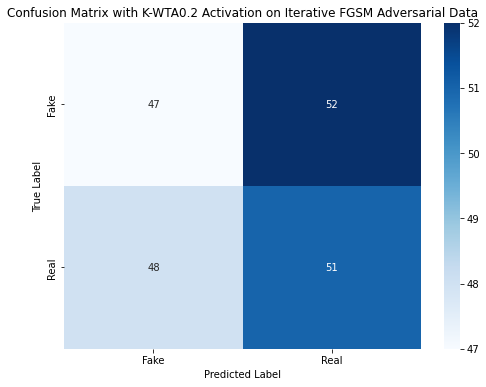

Classification Report with K-WTA0.2 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.49      0.47      0.48        99
        Real       0.50      0.52      0.50        99

    accuracy                           0.49       198
   macro avg       0.49      0.49      0.49       198
weighted avg       0.49      0.49      0.49       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


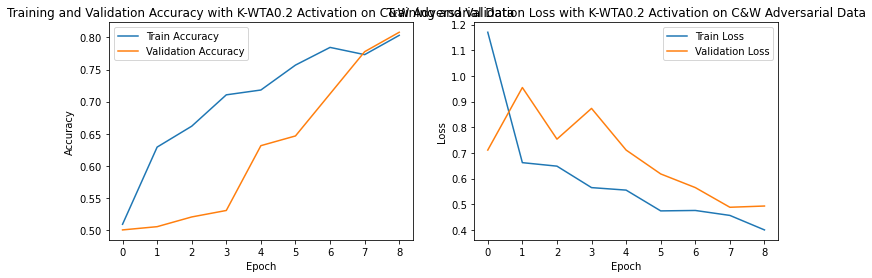

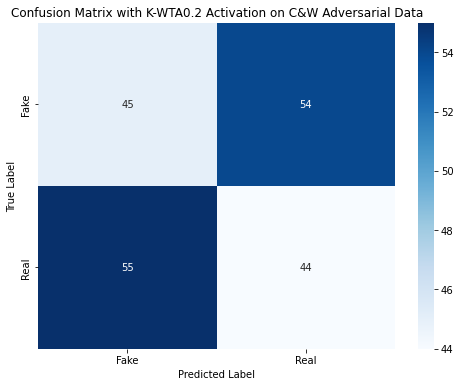

Classification Report with K-WTA0.2 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.45      0.45      0.45        99
        Real       0.45      0.44      0.45        99

    accuracy                           0.45       198
   macro avg       0.45      0.45      0.45       198
weighted avg       0.45      0.45      0.45       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step


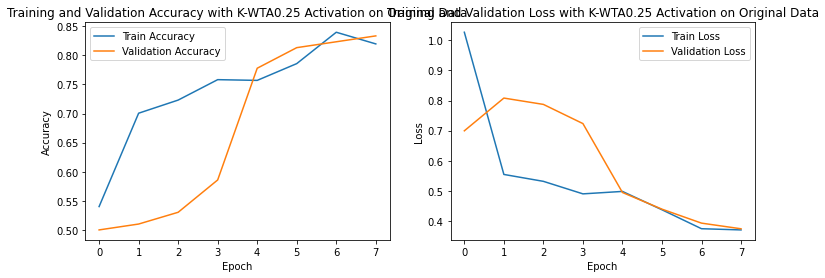

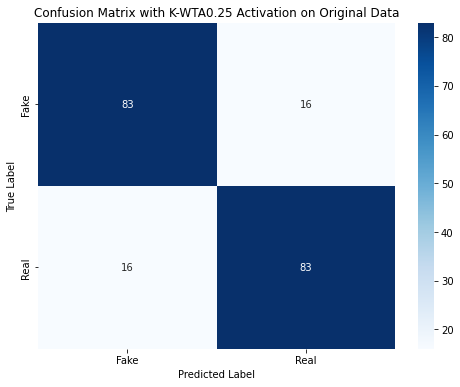

Classification Report with K-WTA0.25 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.84      0.84      0.84        99
        Real       0.84      0.84      0.84        99

    accuracy                           0.84       198
   macro avg       0.84      0.84      0.84       198
weighted avg       0.84      0.84      0.84       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


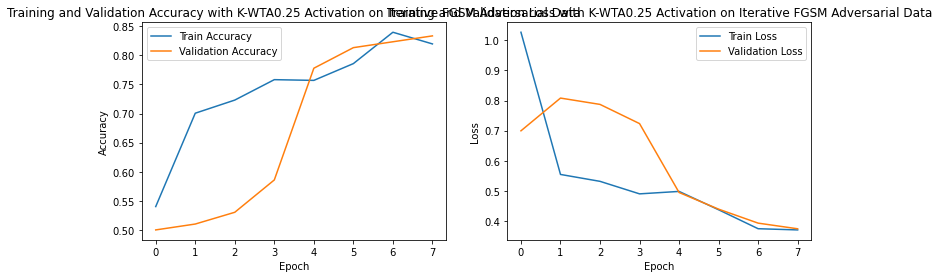

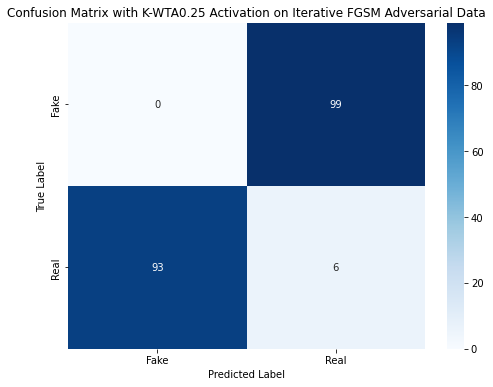

Classification Report with K-WTA0.25 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00        99
        Real       0.06      0.06      0.06        99

    accuracy                           0.03       198
   macro avg       0.03      0.03      0.03       198
weighted avg       0.03      0.03      0.03       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


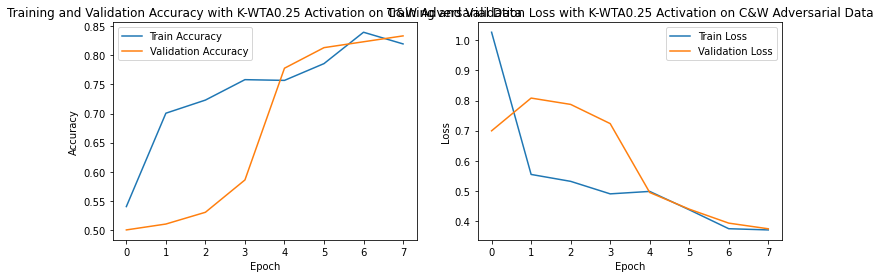

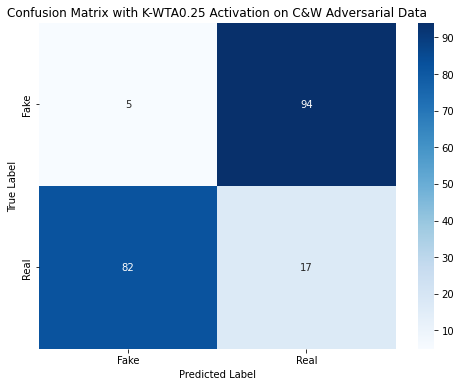

Classification Report with K-WTA0.25 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.06      0.05      0.05        99
        Real       0.15      0.17      0.16        99

    accuracy                           0.11       198
   macro avg       0.11      0.11      0.11       198
weighted avg       0.11      0.11      0.11       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step


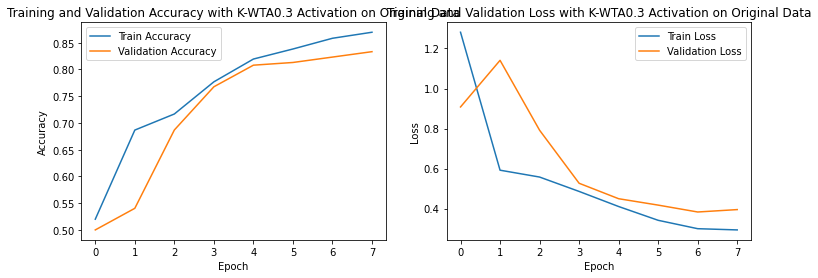

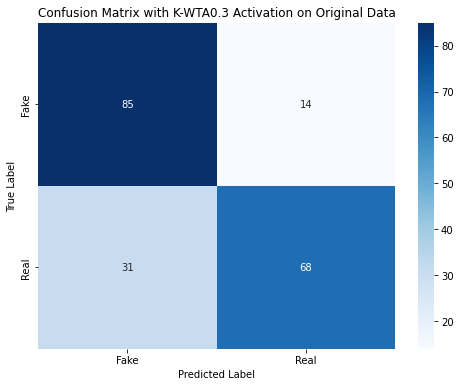

Classification Report with K-WTA0.3 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.73      0.86      0.79        99
        Real       0.83      0.69      0.75        99

    accuracy                           0.77       198
   macro avg       0.78      0.77      0.77       198
weighted avg       0.78      0.77      0.77       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


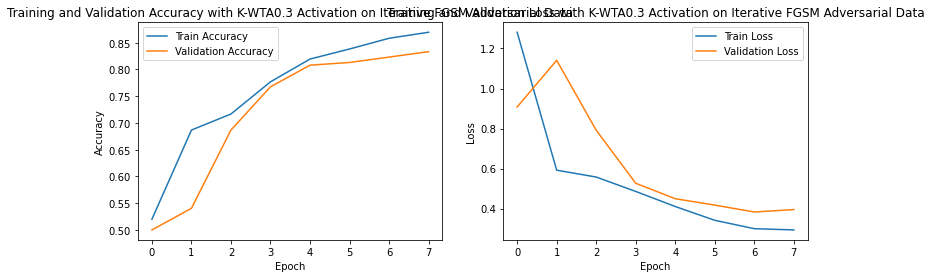

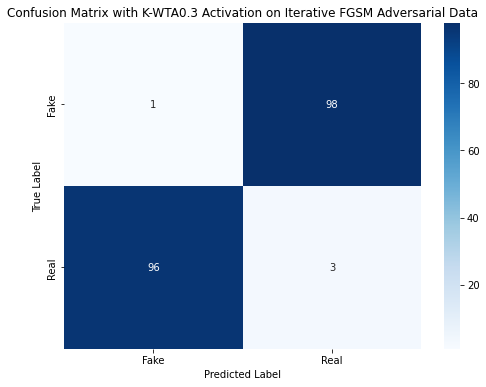

Classification Report with K-WTA0.3 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.01      0.01      0.01        99
        Real       0.03      0.03      0.03        99

    accuracy                           0.02       198
   macro avg       0.02      0.02      0.02       198
weighted avg       0.02      0.02      0.02       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


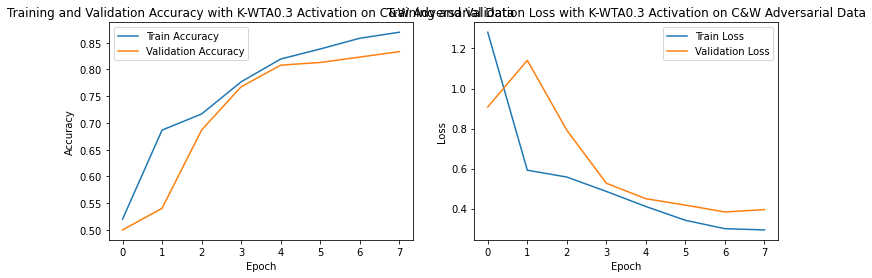

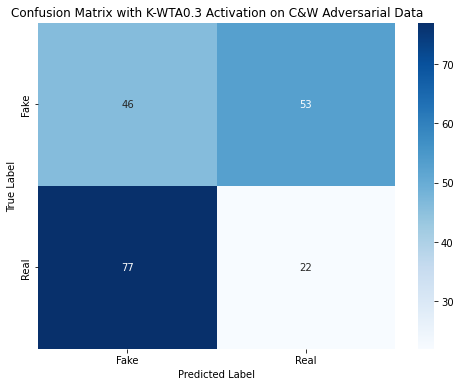

Classification Report with K-WTA0.3 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.37      0.46      0.41        99
        Real       0.29      0.22      0.25        99

    accuracy                           0.34       198
   macro avg       0.33      0.34      0.33       198
weighted avg       0.33      0.34      0.33       198

Found 798 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


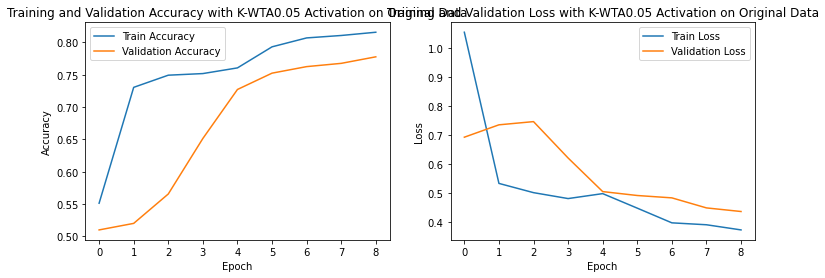

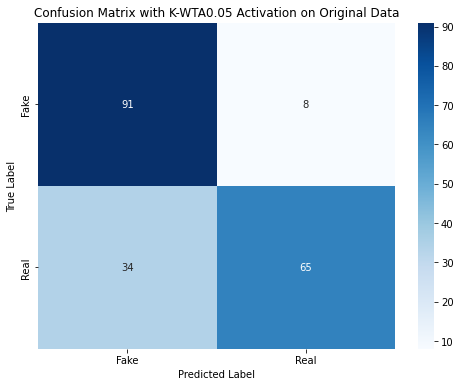

Classification Report with K-WTA0.05 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.73      0.92      0.81        99
        Real       0.89      0.66      0.76        99

    accuracy                           0.79       198
   macro avg       0.81      0.79      0.78       198
weighted avg       0.81      0.79      0.78       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


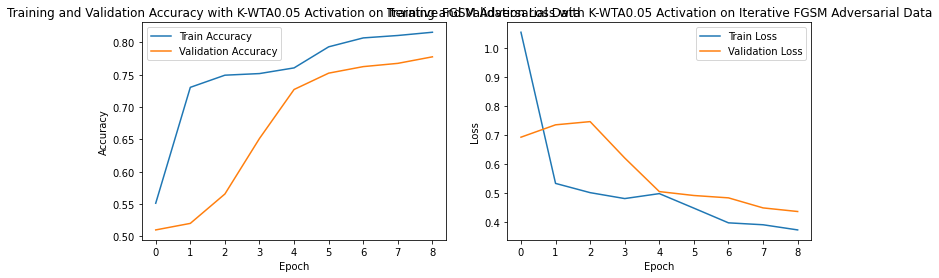

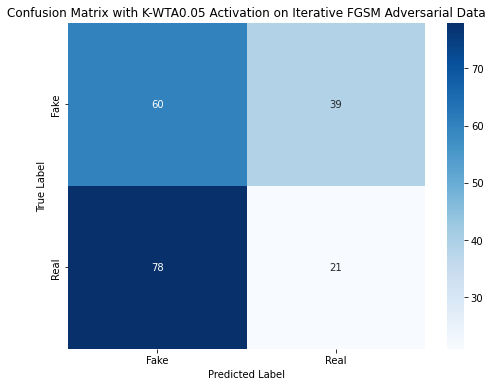

Classification Report with K-WTA0.05 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.43      0.61      0.51        99
        Real       0.35      0.21      0.26        99

    accuracy                           0.41       198
   macro avg       0.39      0.41      0.39       198
weighted avg       0.39      0.41      0.39       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


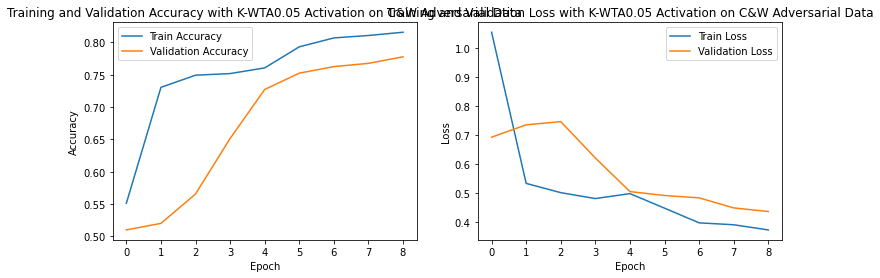

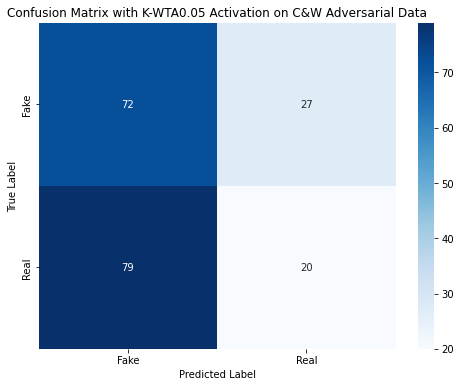

Classification Report with K-WTA0.05 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.48      0.73      0.58        99
        Real       0.43      0.20      0.27        99

    accuracy                           0.46       198
   macro avg       0.45      0.46      0.42       198
weighted avg       0.45      0.46      0.42       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step


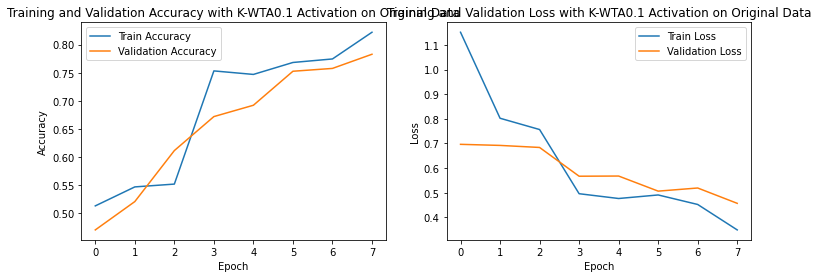

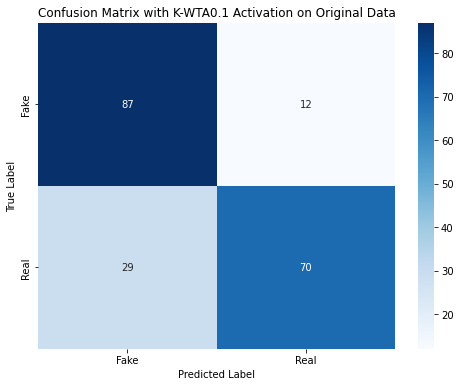

Classification Report with K-WTA0.1 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.75      0.88      0.81        99
        Real       0.85      0.71      0.77        99

    accuracy                           0.79       198
   macro avg       0.80      0.79      0.79       198
weighted avg       0.80      0.79      0.79       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


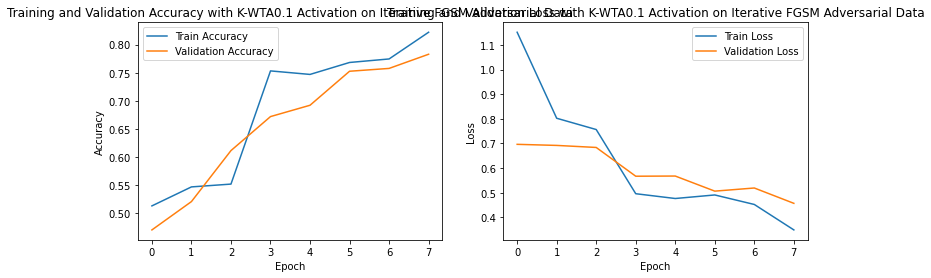

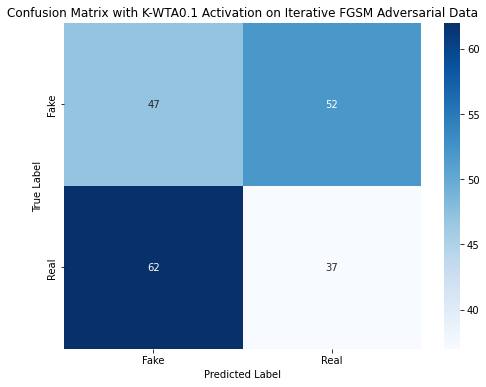

Classification Report with K-WTA0.1 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.43      0.47      0.45        99
        Real       0.42      0.37      0.39        99

    accuracy                           0.42       198
   macro avg       0.42      0.42      0.42       198
weighted avg       0.42      0.42      0.42       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


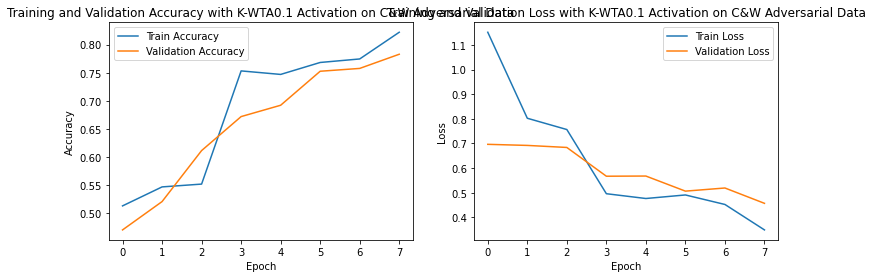

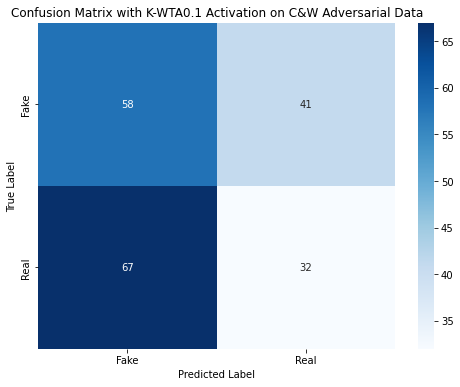

Classification Report with K-WTA0.1 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.46      0.59      0.52        99
        Real       0.44      0.32      0.37        99

    accuracy                           0.45       198
   macro avg       0.45      0.45      0.44       198
weighted avg       0.45      0.45      0.44       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step


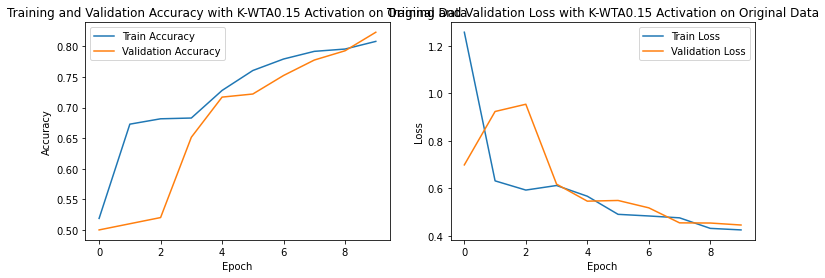

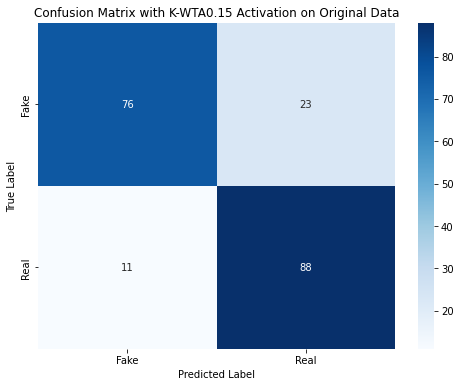

Classification Report with K-WTA0.15 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.87      0.77      0.82        99
        Real       0.79      0.89      0.84        99

    accuracy                           0.83       198
   macro avg       0.83      0.83      0.83       198
weighted avg       0.83      0.83      0.83       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


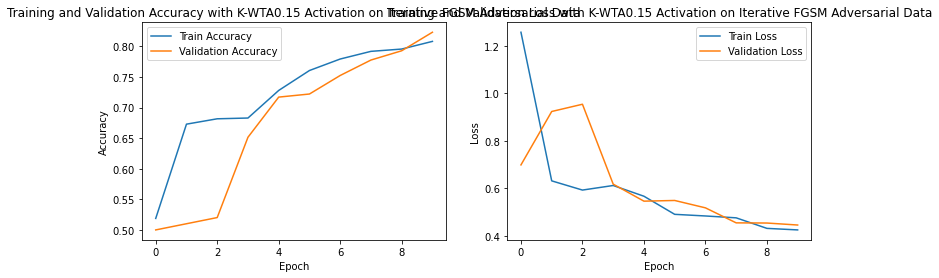

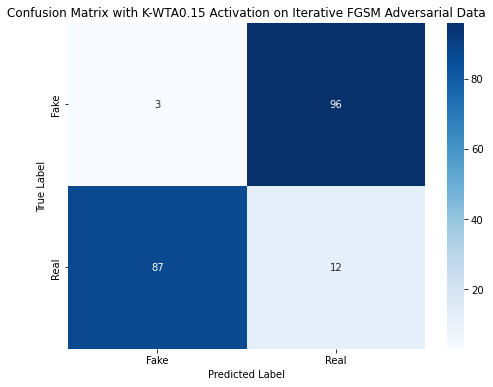

Classification Report with K-WTA0.15 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.03      0.03      0.03        99
        Real       0.11      0.12      0.12        99

    accuracy                           0.08       198
   macro avg       0.07      0.08      0.07       198
weighted avg       0.07      0.08      0.07       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


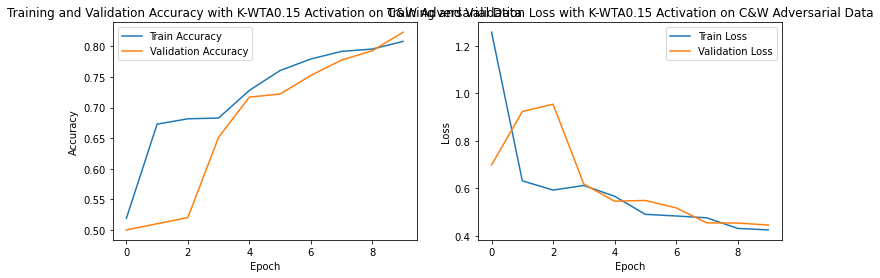

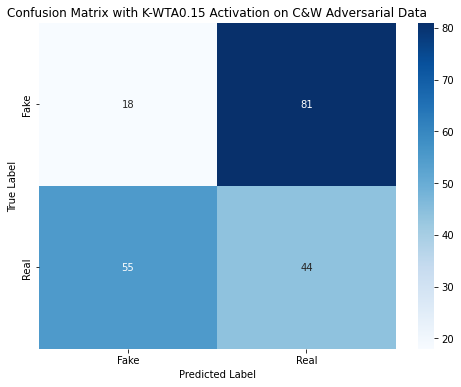

Classification Report with K-WTA0.15 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.25      0.18      0.21        99
        Real       0.35      0.44      0.39        99

    accuracy                           0.31       198
   macro avg       0.30      0.31      0.30       198
weighted avg       0.30      0.31      0.30       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


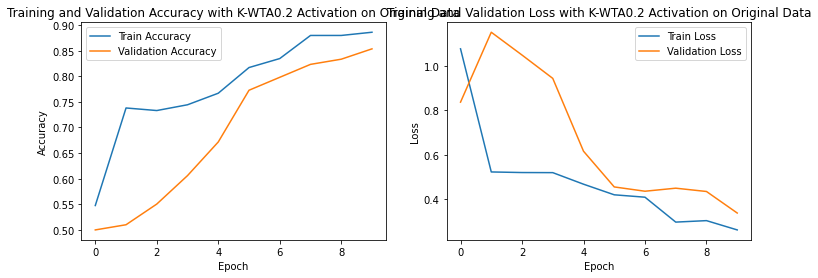

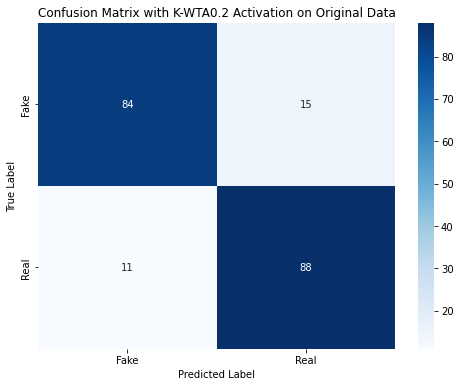

Classification Report with K-WTA0.2 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.88      0.85      0.87        99
        Real       0.85      0.89      0.87        99

    accuracy                           0.87       198
   macro avg       0.87      0.87      0.87       198
weighted avg       0.87      0.87      0.87       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


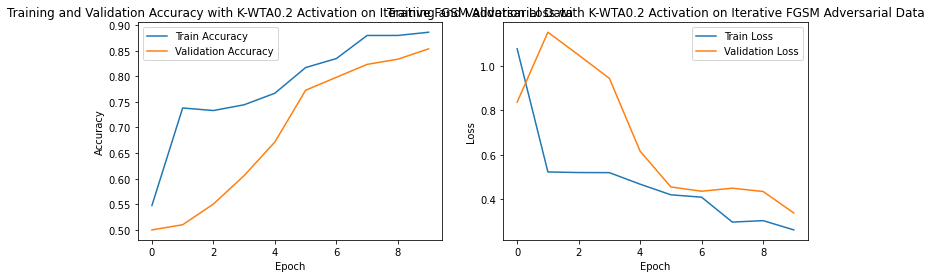

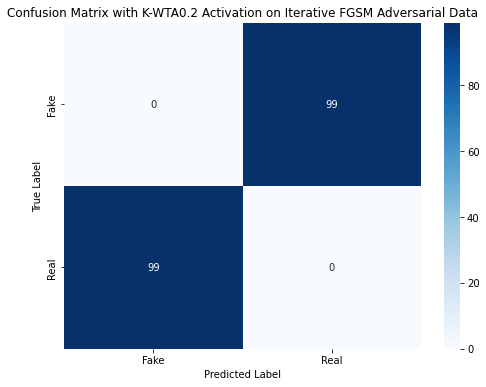

Classification Report with K-WTA0.2 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00      99.0
        Real       0.00      0.00      0.00      99.0

    accuracy                           0.00     198.0
   macro avg       0.00      0.00      0.00     198.0
weighted avg       0.00      0.00      0.00     198.0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


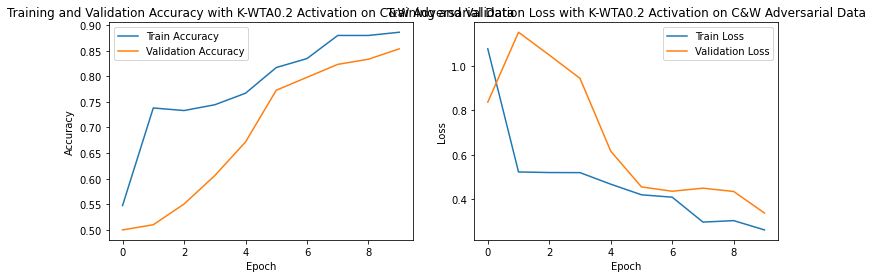

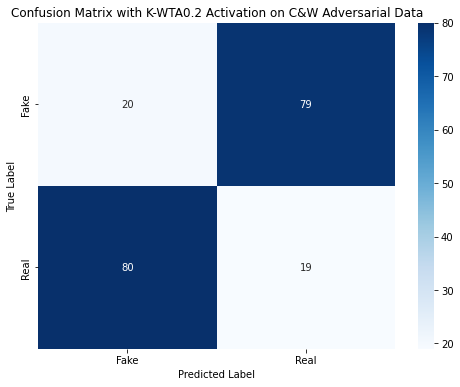

Classification Report with K-WTA0.2 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.20      0.20      0.20        99
        Real       0.19      0.19      0.19        99

    accuracy                           0.20       198
   macro avg       0.20      0.20      0.20       198
weighted avg       0.20      0.20      0.20       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step


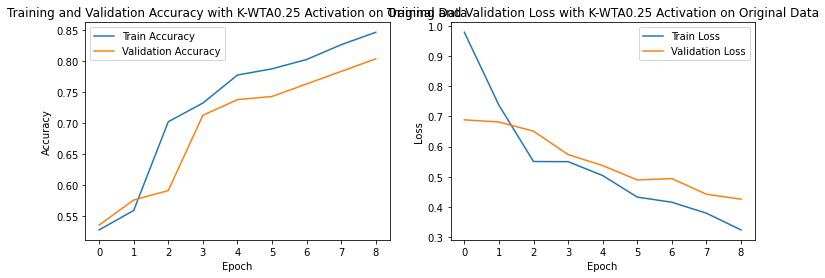

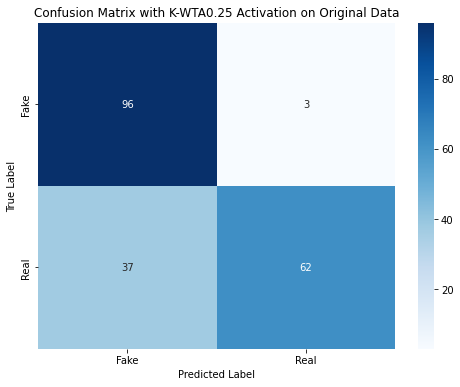

Classification Report with K-WTA0.25 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.72      0.97      0.83        99
        Real       0.95      0.63      0.76        99

    accuracy                           0.80       198
   macro avg       0.84      0.80      0.79       198
weighted avg       0.84      0.80      0.79       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


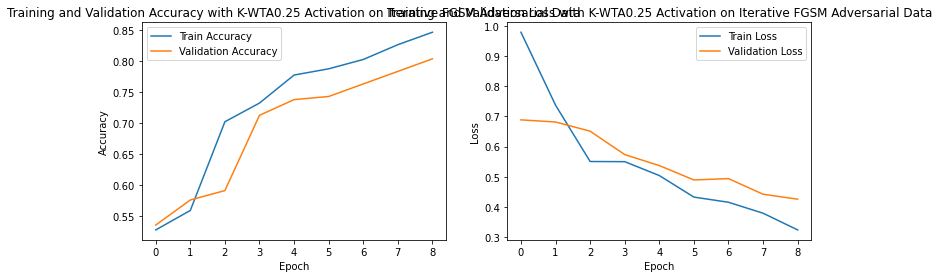

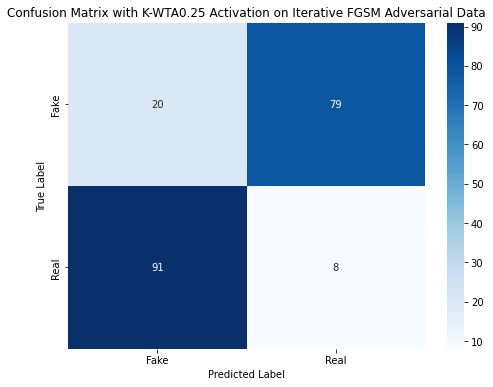

Classification Report with K-WTA0.25 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.18      0.20      0.19        99
        Real       0.09      0.08      0.09        99

    accuracy                           0.14       198
   macro avg       0.14      0.14      0.14       198
weighted avg       0.14      0.14      0.14       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


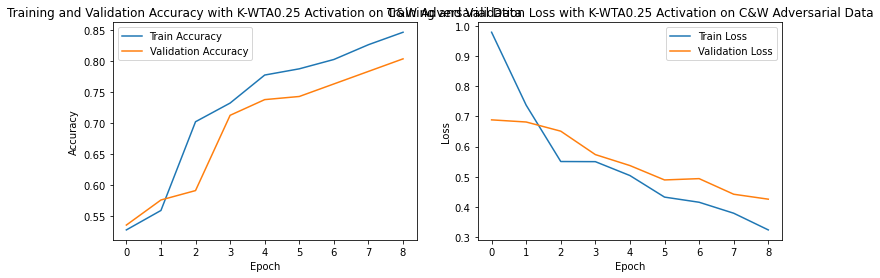

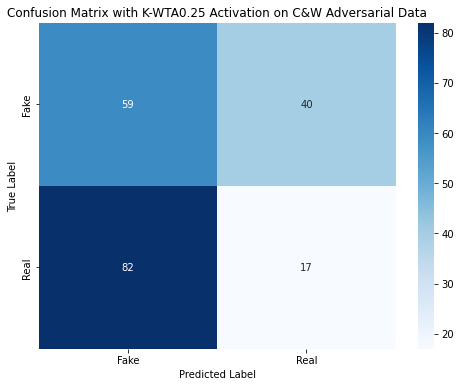

Classification Report with K-WTA0.25 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.42      0.60      0.49        99
        Real       0.30      0.17      0.22        99

    accuracy                           0.38       198
   macro avg       0.36      0.38      0.35       198
weighted avg       0.36      0.38      0.35       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step


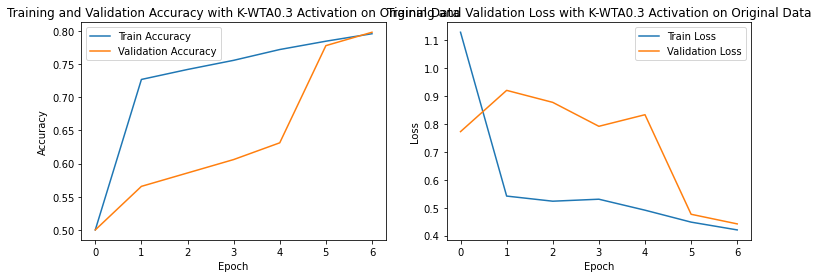

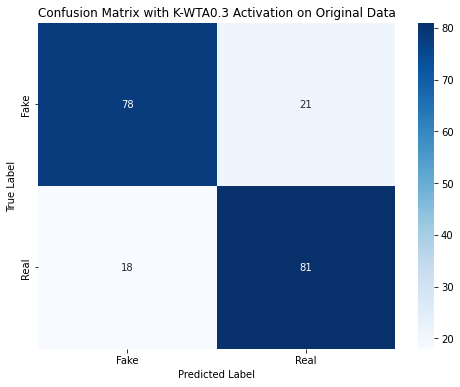

Classification Report with K-WTA0.3 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.81      0.79      0.80        99
        Real       0.79      0.82      0.81        99

    accuracy                           0.80       198
   macro avg       0.80      0.80      0.80       198
weighted avg       0.80      0.80      0.80       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


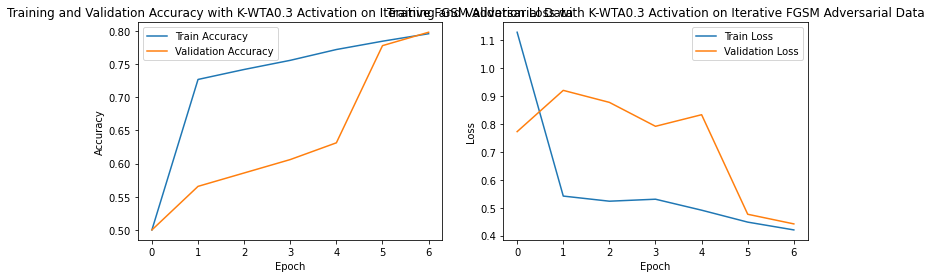

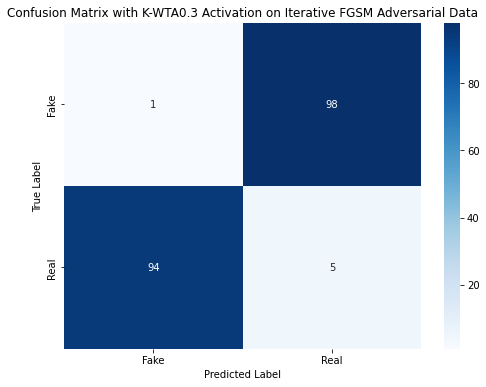

Classification Report with K-WTA0.3 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.01      0.01      0.01        99
        Real       0.05      0.05      0.05        99

    accuracy                           0.03       198
   macro avg       0.03      0.03      0.03       198
weighted avg       0.03      0.03      0.03       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


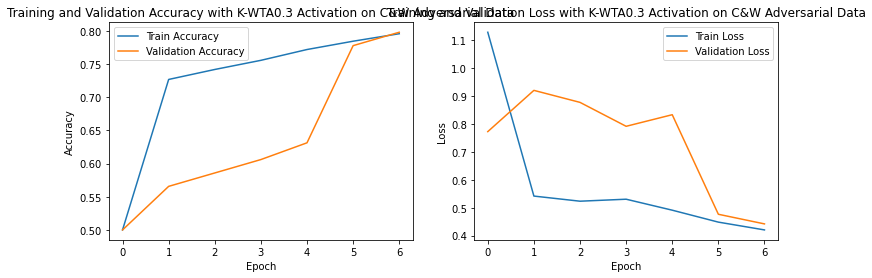

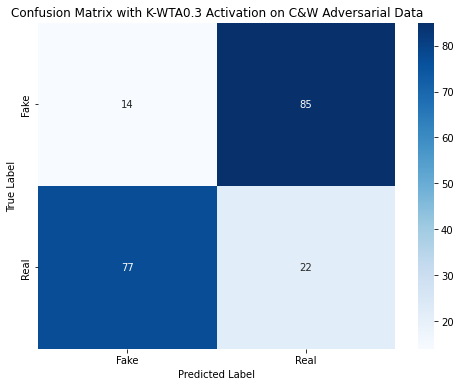

Classification Report with K-WTA0.3 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.15      0.14      0.15        99
        Real       0.21      0.22      0.21        99

    accuracy                           0.18       198
   macro avg       0.18      0.18      0.18       198
weighted avg       0.18      0.18      0.18       198

Found 798 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


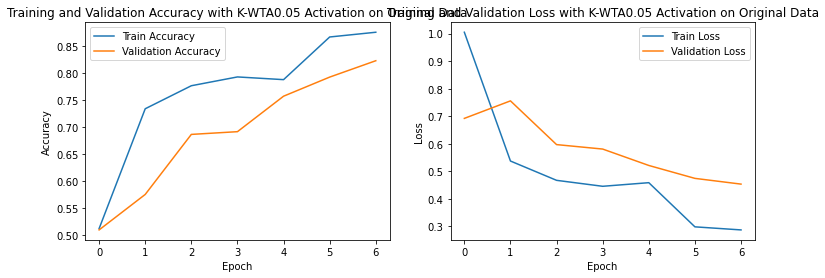

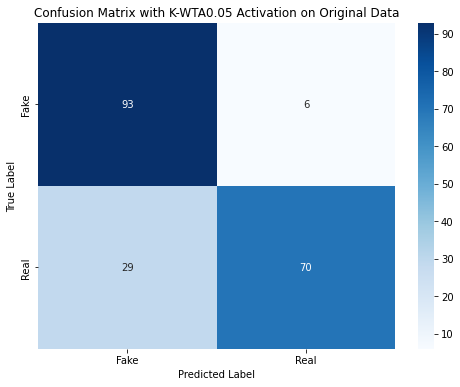

Classification Report with K-WTA0.05 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.76      0.94      0.84        99
        Real       0.92      0.71      0.80        99

    accuracy                           0.82       198
   macro avg       0.84      0.82      0.82       198
weighted avg       0.84      0.82      0.82       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


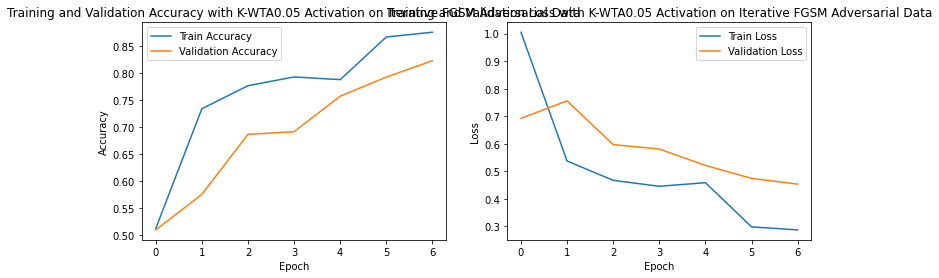

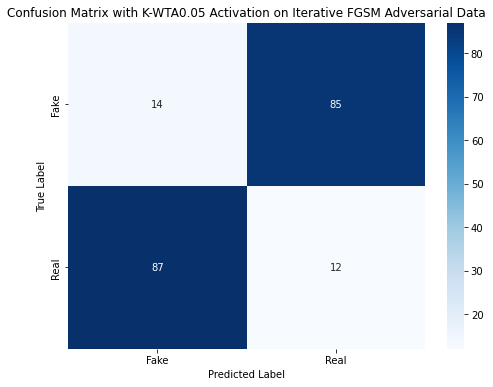

Classification Report with K-WTA0.05 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.14      0.14      0.14        99
        Real       0.12      0.12      0.12        99

    accuracy                           0.13       198
   macro avg       0.13      0.13      0.13       198
weighted avg       0.13      0.13      0.13       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


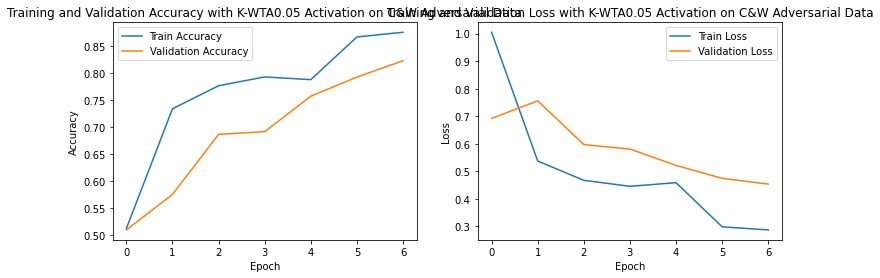

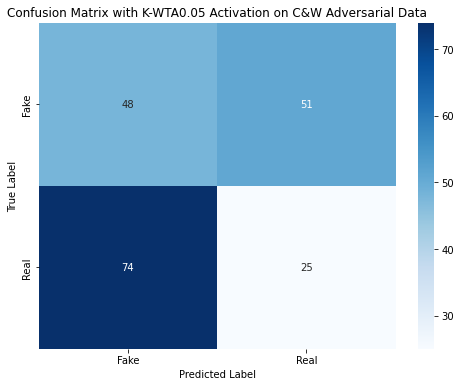

Classification Report with K-WTA0.05 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.39      0.48      0.43        99
        Real       0.33      0.25      0.29        99

    accuracy                           0.37       198
   macro avg       0.36      0.37      0.36       198
weighted avg       0.36      0.37      0.36       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step


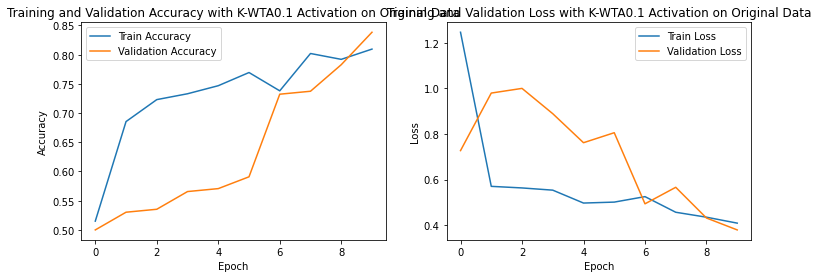

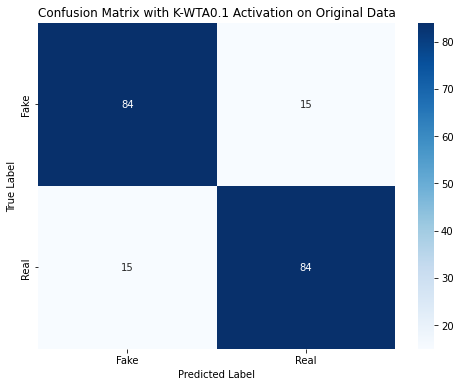

Classification Report with K-WTA0.1 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.85      0.85      0.85        99
        Real       0.85      0.85      0.85        99

    accuracy                           0.85       198
   macro avg       0.85      0.85      0.85       198
weighted avg       0.85      0.85      0.85       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


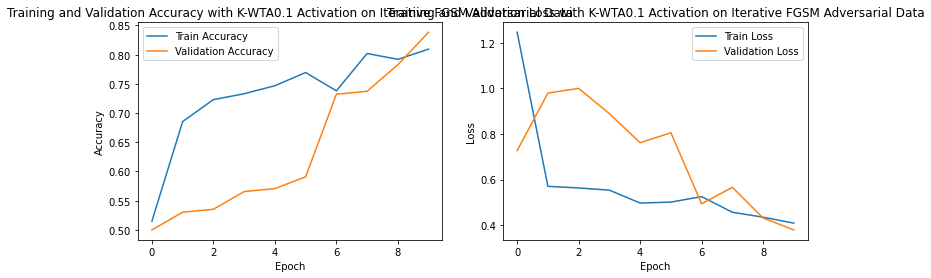

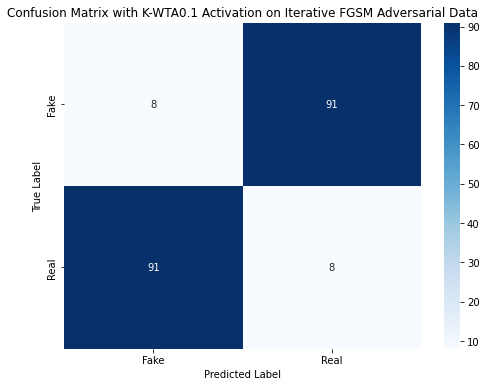

Classification Report with K-WTA0.1 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.08      0.08      0.08        99
        Real       0.08      0.08      0.08        99

    accuracy                           0.08       198
   macro avg       0.08      0.08      0.08       198
weighted avg       0.08      0.08      0.08       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


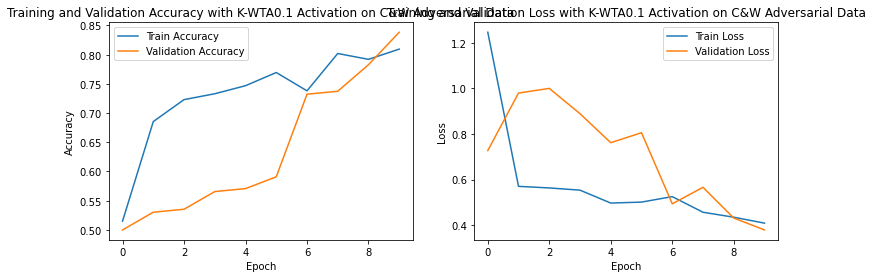

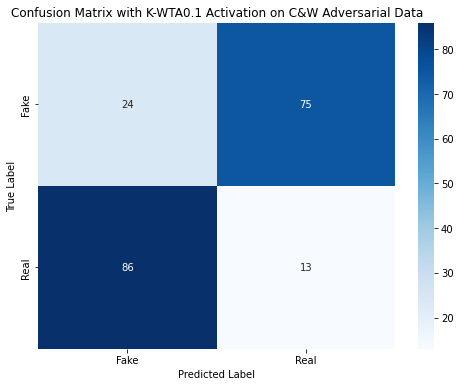

Classification Report with K-WTA0.1 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.22      0.24      0.23        99
        Real       0.15      0.13      0.14        99

    accuracy                           0.19       198
   macro avg       0.18      0.19      0.18       198
weighted avg       0.18      0.19      0.18       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step


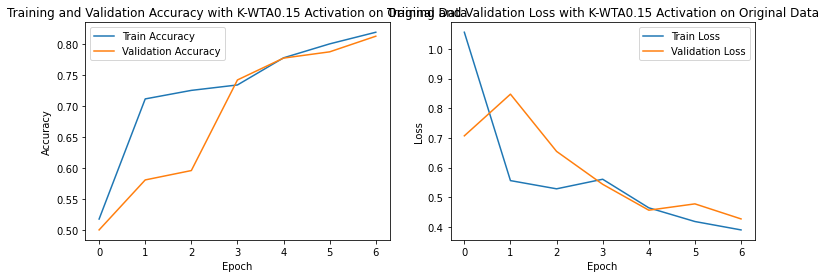

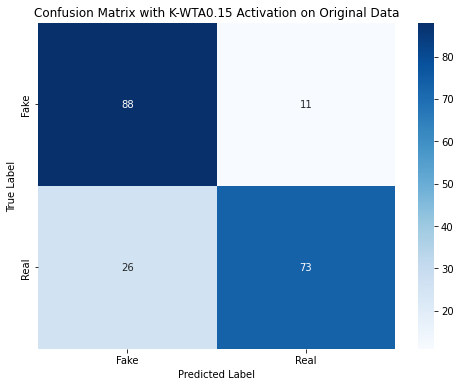

Classification Report with K-WTA0.15 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.77      0.89      0.83        99
        Real       0.87      0.74      0.80        99

    accuracy                           0.81       198
   macro avg       0.82      0.81      0.81       198
weighted avg       0.82      0.81      0.81       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


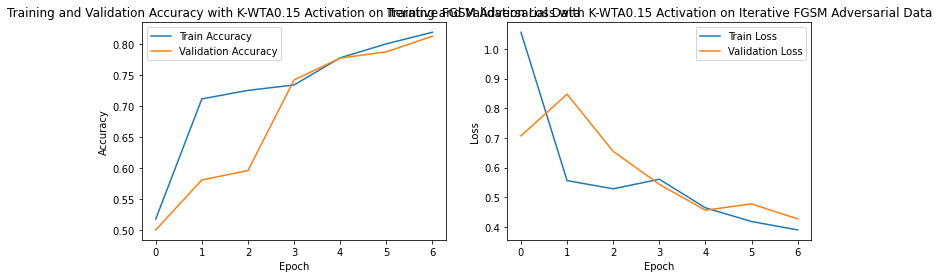

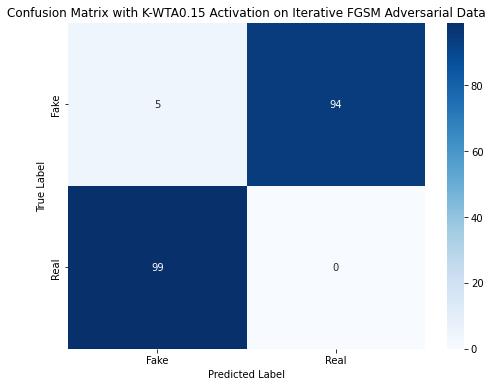

Classification Report with K-WTA0.15 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.05      0.05      0.05        99
        Real       0.00      0.00      0.00        99

    accuracy                           0.03       198
   macro avg       0.02      0.03      0.02       198
weighted avg       0.02      0.03      0.02       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


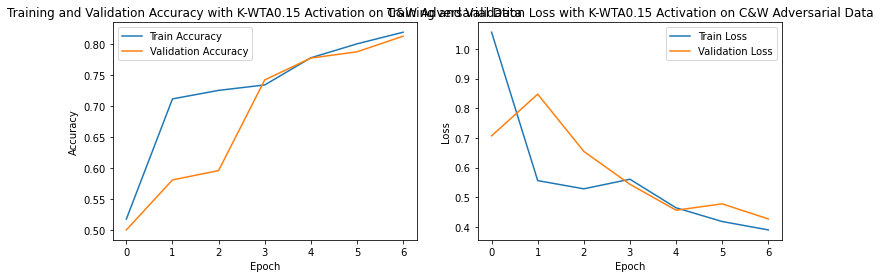

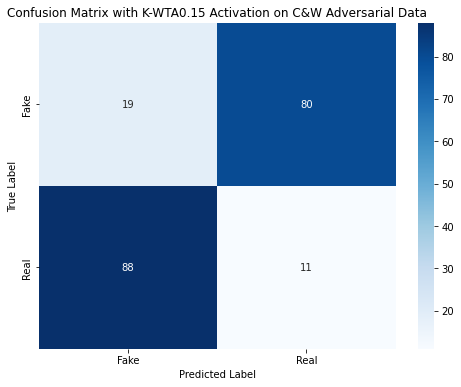

Classification Report with K-WTA0.15 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.18      0.19      0.18        99
        Real       0.12      0.11      0.12        99

    accuracy                           0.15       198
   macro avg       0.15      0.15      0.15       198
weighted avg       0.15      0.15      0.15       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


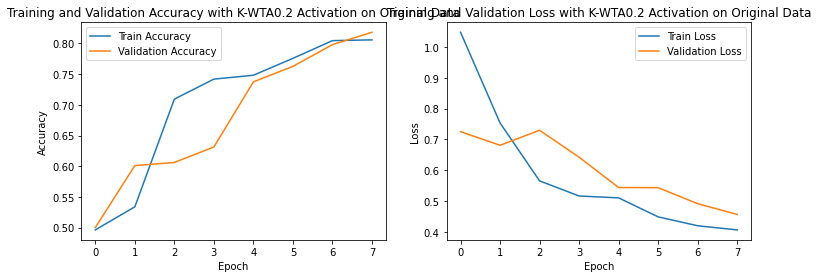

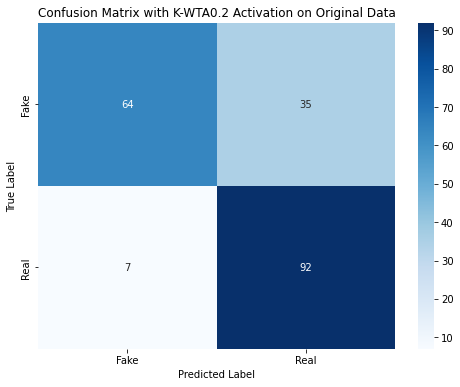

Classification Report with K-WTA0.2 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.90      0.65      0.75        99
        Real       0.72      0.93      0.81        99

    accuracy                           0.79       198
   macro avg       0.81      0.79      0.78       198
weighted avg       0.81      0.79      0.78       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


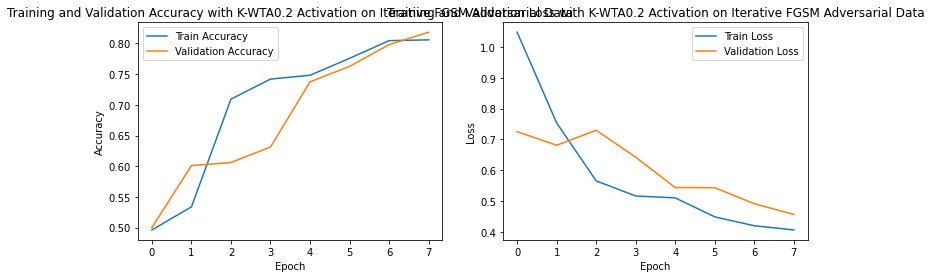

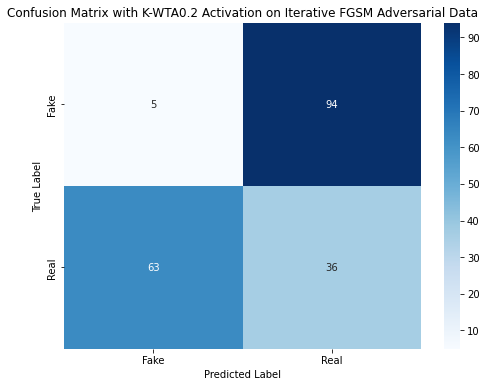

Classification Report with K-WTA0.2 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.07      0.05      0.06        99
        Real       0.28      0.36      0.31        99

    accuracy                           0.21       198
   macro avg       0.18      0.21      0.19       198
weighted avg       0.18      0.21      0.19       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


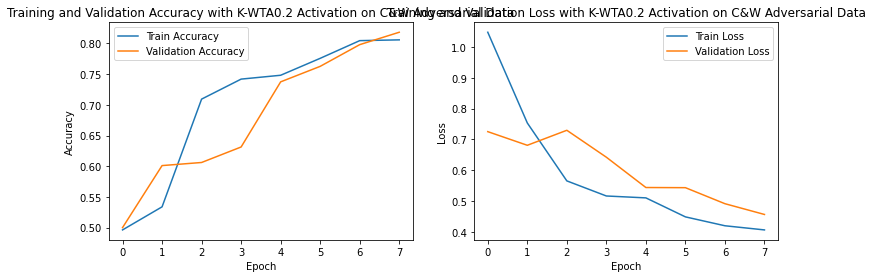

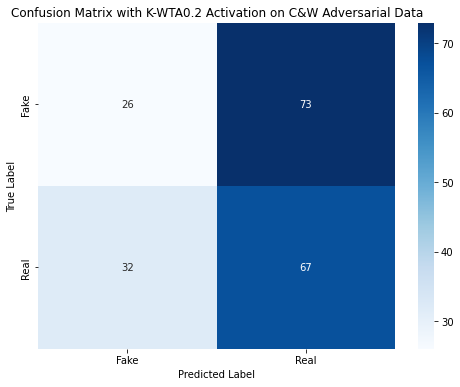

Classification Report with K-WTA0.2 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.45      0.26      0.33        99
        Real       0.48      0.68      0.56        99

    accuracy                           0.47       198
   macro avg       0.46      0.47      0.45       198
weighted avg       0.46      0.47      0.45       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


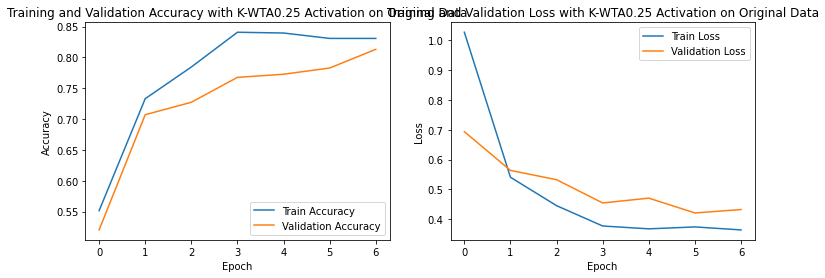

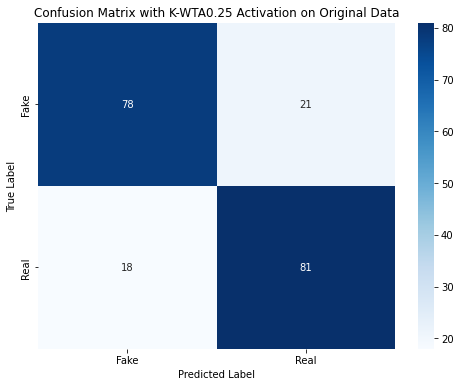

Classification Report with K-WTA0.25 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.81      0.79      0.80        99
        Real       0.79      0.82      0.81        99

    accuracy                           0.80       198
   macro avg       0.80      0.80      0.80       198
weighted avg       0.80      0.80      0.80       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


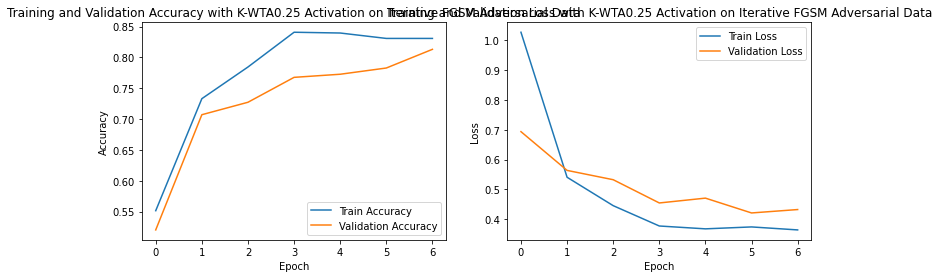

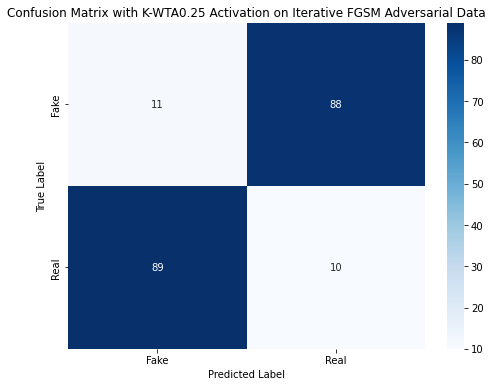

Classification Report with K-WTA0.25 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.11      0.11      0.11        99
        Real       0.10      0.10      0.10        99

    accuracy                           0.11       198
   macro avg       0.11      0.11      0.11       198
weighted avg       0.11      0.11      0.11       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


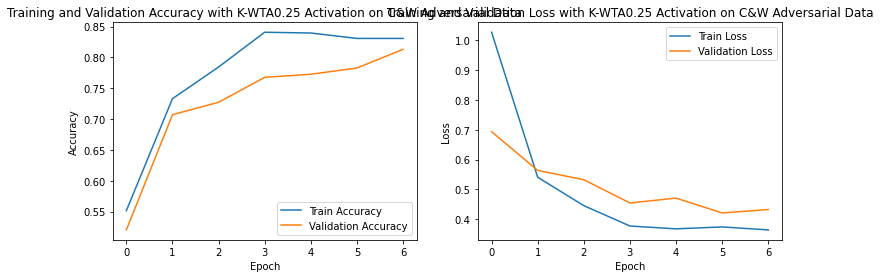

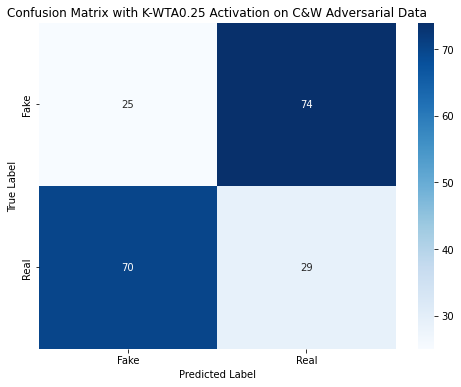

Classification Report with K-WTA0.25 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.26      0.25      0.26        99
        Real       0.28      0.29      0.29        99

    accuracy                           0.27       198
   macro avg       0.27      0.27      0.27       198
weighted avg       0.27      0.27      0.27       198



/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/keras/src/activations/__init__.py:54: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         activation = lambda x: k_wta(x, percent=percent)

  fn_config = serializa

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step


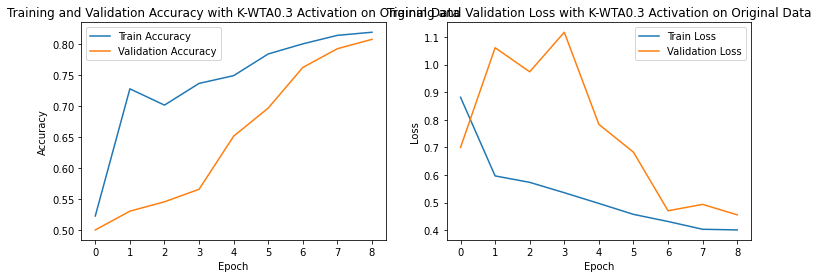

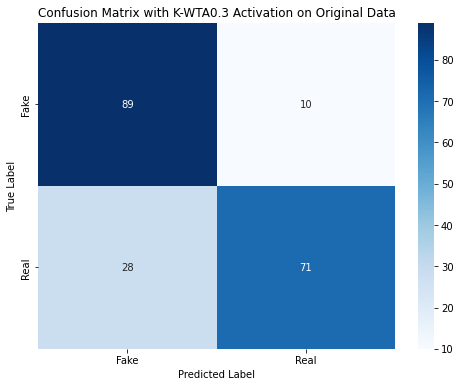

Classification Report with K-WTA0.3 Activation on Original Data:
              precision    recall  f1-score   support

        Fake       0.76      0.90      0.82        99
        Real       0.88      0.72      0.79        99

    accuracy                           0.81       198
   macro avg       0.82      0.81      0.81       198
weighted avg       0.82      0.81      0.81       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


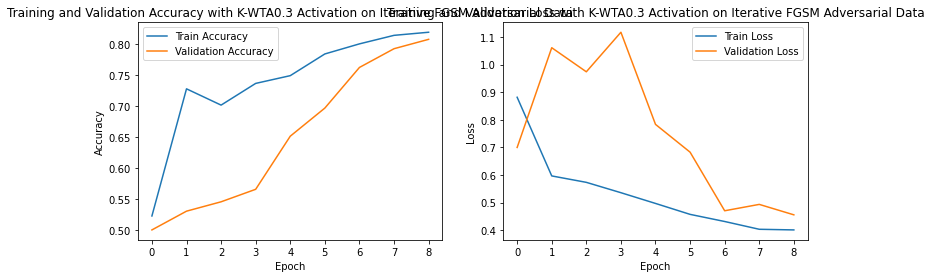

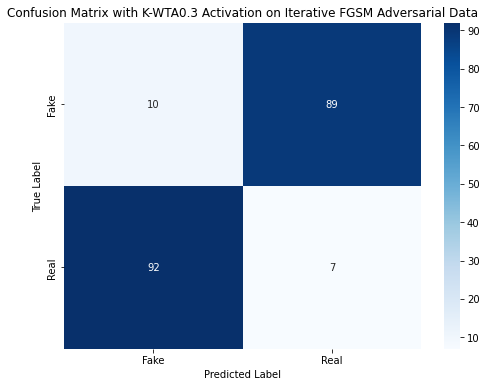

Classification Report with K-WTA0.3 Activation on Iterative FGSM Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.10      0.10      0.10        99
        Real       0.07      0.07      0.07        99

    accuracy                           0.09       198
   macro avg       0.09      0.09      0.09       198
weighted avg       0.09      0.09      0.09       198

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


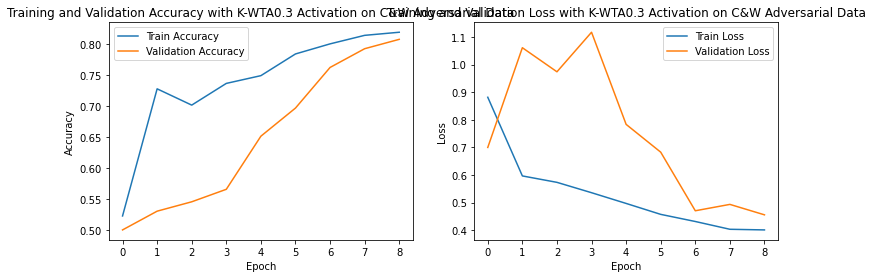

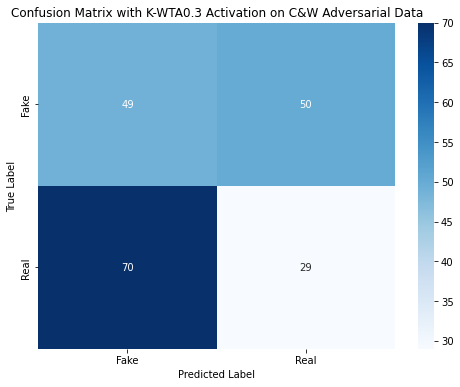

Classification Report with K-WTA0.3 Activation on C&W Adversarial Data:
              precision    recall  f1-score   support

        Fake       0.41      0.49      0.45        99
        Real       0.37      0.29      0.33        99

    accuracy                           0.39       198
   macro avg       0.39      0.39      0.39       198
weighted avg       0.39      0.39      0.39       198



In [ ]:
def main(train_dir, epochs):
    train_generator, validation_generator = prepare_data(train_dir)

    # Evaluate original Meso-4 model with ReLU on original validation data
    validation_images = []
    validation_labels = []

    for batch_index in range(len(validation_generator)):
        images, labels = validation_generator[batch_index]
        validation_images.append(images)
        validation_labels.append(labels)

    validation_images = np.vstack(validation_images)
    validation_labels = np.hstack(validation_labels)

    percents = [0.05,0.10,0.15,0.20,0.25,0.30]
    for percent in percents:
        model_k_wta = build_model(activation='k_wta', percent=percent)
        history_k_wta = train_model(model_k_wta, train_generator, validation_generator, epochs)

        cm_k_wta, cr_k_wta = evaluate_model(model_k_wta, validation_images, validation_labels)
        plot_results(history_k_wta, cm_k_wta, cr_k_wta, f'with K-WTA{percent} Activation on Original Data')

        adv_images_ifgsm_k_wta = []
        for image, label in zip(validation_images, validation_labels):
            adv_image_ifgsm_k_wta = iterative_fgsm(model_k_wta, image,label)
            adv_images_ifgsm_k_wta.append(tf.expand_dims(adv_image_ifgsm_k_wta, axis=0))
        adv_images_ifgsm_k_wta = np.vstack(adv_images_ifgsm_k_wta)

        cm_adv_ifgsm_k_wta, cr_adv_ifgsm_k_wta = evaluate_model(model_k_wta, adv_images_ifgsm_k_wta, validation_labels)
        plot_results(history_k_wta, cm_adv_ifgsm_k_wta, cr_adv_ifgsm_k_wta, f'with K-WTA{percent} Activation on Iterative FGSM Adversarial Data')

        adv_images_cw_k_wta = []
        for image, label in zip(validation_images, validation_labels):
            adv_image_cw_k_wta = carlini_wagner_l2(model_k_wta, image,label)
            adv_images_cw_k_wta.append(tf.expand_dims(adv_image_cw_k_wta, axis=0))

        adv_images_cw_k_wta = np.vstack(adv_images_cw_k_wta)

        cm_adv_cw_k_wta, cr_adv_cw_k_wta = evaluate_model(model_k_wta, adv_images_cw_k_wta, validation_labels)
        plot_results(history_k_wta, cm_adv_cw_k_wta, cr_adv_cw_k_wta, f'with K-WTA{percent} Activation on C&W Adversarial Data')

if __name__ == "__main__":
    train_dir = '/home/user/Downloads/extracted_faces_deepfake'
    for i in range(5):
        main(train_dir, epochs=30)